***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document 8 pre1</span> 

# Helmholtz Machine Complete Version


*Updated:* Jan 12, 2024


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [5]:
def one_step_para_init(n_dz_slice,init_type):
    """
    Arguments:
    n_dz_slice -- 2 columns of n_dz
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian

    Returns:
    Phi, Theta -- -2 column bias, -1 column scale
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,2), last row is counts, column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    """
    l = np.where(n_dz_slice[:,0] != 0)[0].size  # number of layers
    layer_vt = np.append(n_dz_slice[:l,0],n_dz_slice[0,1])
    Phi = {}
    Theta = {}
    norm_wake = {}
    norm_sleep = {}
    for i in range(l):
        if init_type == "zero":
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((layer_vt[i+1],layer_vt[i]+2))
            Theta["Theta_" + str(l-i) + str(l-i-1)] = np.zeros((layer_vt[l-i-1],layer_vt[l-i]+2))
        elif init_type == "random":
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(layer_vt[i+1],layer_vt[i]+2)
            Theta["Theta_" + str(l-i) + str(l-i-1)] = np.random.randn(layer_vt[l-i-1],layer_vt[l-i]+2)
        else:
            raise Exception("Wrong Init Type")
        Phi["Phi_" + str(i) + str(i+1)][:,-1] = 1          #scale
        Theta["Theta_" + str(l-i) + str(l-i-1)][:,-1] = 1
        Phi["Phi_" + str(i) + str(i+1)][:,-2] = 0              #bias
        Theta["Theta_" + str(l-i) + str(l-i-1)][:,-2] = 0
        
        norm_wake["l_" + str(i+1)] = np.zeros((layer_vt[i+1]+1,3))
        norm_sleep["l_" + str(l-i-1)] = np.zeros((layer_vt[l-i-1]+1,3))
        
    return Phi,Theta,norm_wake,norm_sleep

In [6]:
def one_step_forward(x,activation_type,parameter_set,norm_set,add_norm):
    """
    Arguments:
    x -- input instantiation layer, numpy array of shape (n,1)
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Python dictionary of length l. The keys are ordered sequentially from layer x to y.
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,2), last row: counts; column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    add_norm -- True or False. Update norm matrix or not
    
    Returns:
    G -- activation of each layer including x
    q -- probability of layer y
    """
    l = len(parameter_set)
    p_keys = [*parameter_set]
    n_keys = [*norm_set]
    G = {'z0': x}
    g = x
    
    for i in range(l):
        phi = parameter_set[p_keys[i]]
        norm = norm_set[n_keys[i]]
        
        pre_ac = np.matmul(phi[:,:-2],g)+norm[:-1,2:]  # pre-activation; bias placeholder
        K = phi[:,-1:] * pre_ac + phi[:,-2:-1]  # rescale linear term
        if activation_type == "sigmoid":
            g = sigmoid(K)
        elif activation_type == "tanh":
            g = np.tanh(K)
        if i == l-1:
            g = sigmoid(K)
        G['z'+str(i+1)] = g
        
        if add_norm == True:
            norm[:-1,0:1] += pre_ac
            norm[-1,0] += 1
            norm[:-1,1:2] += pre_ac**2
            norm[-1,1] += 1
            norm_set[n_keys[i]] = norm        
    return G,g

In [7]:
def one_step_update(x,y,G,activation_type,parameter_set,value_set,norm_set,lr,\
                    fz_binary,fz_scale,fz_W,layer_norm,layer_norm_rate,check_lr):
    """
    Arguments:
    x -- input sampling layer, numpy array of shape (n,1)
    y -- target sampling layer, numpy array of shape (m,1)
    G -- output of one_step_forward_norm, activation of each layer including x
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Each array phi: -2 column bias, -1 column scale
    value_set -- list or array [[a_x,b_x],[a_y,b_y]], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,3), last row: counts; column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    lr -- learning rate, decimals
    fz_binary -- True or Flase. If True, [a_x,b_x] are fixed values; if False, update [a_x,b_x]
    fz_scale -- True or Flase. If True, last 2 columns of phi are fixed; if False, update adaptive scale and bias
    fz_W -- True or Flase. If True, freeze weights; if False, update weights
    layer_norm -- True or Flase, whether to adjust row distribution of W (more evenly distributed) by adjusting the 
    updating rate "layer_norm_rate" of dW
    check_lr -- True or Flase. If True, check current lr and update it as needed
    
    Returns:
    parameter_set -- updated parameters
    loss -- value of loss function before updating, a number
    grad_set -- gradients of parameters
    lr -- updated learning rate
    """
    
    a_x = value_set[0,0]
    b_x = value_set[0,1]
    a_y = value_set[1,0]
    b_y = value_set[1,1]
    l = len(parameter_set)
    p_keys = [*parameter_set]
    n_keys = [*norm_set]
    grad_set = {}
    
    # derivatives
    q = G['z'+str(l)]
    u = q - (y-b_y)/(a_y-b_y)   #[n_y,1]
    loss = -np.sum(((y-b_y)*np.log(q) + (a_y-y)*np.log(1-q))/(a_y-b_y))  # layer entropy loss
    if np.where(np.abs(y - a_y) < 1e-8)[0].size + np.where(np.abs(y - b_y) < 1e-8)[0].size != y.size:
        raise Exception("Incorrect output layer" + str(a_y)+ " "+str(b_y)+ " "+str(y))
    # a = g(scale * [(Wz+b-mean)/deviation] + bias)
    for i in range(l-1,-1,-1):
        phi = parameter_set[p_keys[i]]
        grad_set['d_'+p_keys[i]] = np.zeros(phi.shape)
        W = phi[:,:-2]        #[n_y,n_z]
        bias = phi[:,-2:-1]   #[n_y,1]
        scale = phi[:,-1:]    #[n_y,1]
        
        z = G['z'+str(i)]      #[n_z,1]
        
        if fz_W == False:
            dW = np.outer(u*scale,z)     #[n_y,n_z]
            grad_set['d_'+p_keys[i]][:,:-2] = dW
            # update weights
            if layer_norm == True:
                dW = layer_lr(W, dW, rate=layer_norm_rate)
            parameter_set[p_keys[i]][:,:-2] -= lr * dW
        
        if fz_scale == False:
#             norm = norm_set[n_keys[i]]      #[n_y,3]
#             b = norm[:-1,2:]                #[n_y,1]
#             N = np.matmul(W,z)+b   #[n_y,1]
#             d_scale = u * N/np.sqrt((N**2).sum())     #[n_y,1]
            d_bias = u             #[n_y,1]
#             parameter_set[p_keys[i]][:,-1:] -= lr * d_scale
            parameter_set[p_keys[i]][:,-2:-1] -= lr * d_bias
#             grad_set['d_'+p_keys[i]][:,-1:] = d_scale
            grad_set['d_'+p_keys[i]][:,-2:-1] = d_bias
        
        dz = np.matmul(W.T,u*scale)  #[n_z,1]
        if i > 0:
            if activation_type == "sigmoid":
                u = dz * z * (1-z)
            elif activation_type == "tanh":
                u = dz * (1-z**2)
        else:
            # input layer, parameters a_x, b_x
            if fz_binary == False:
                d_ax = np.mean(dz[np.where(np.abs(x - a_x) < 1e-8)[0]]) # use mean instead of sum
                d_bx = np.mean(dz[np.where(np.abs(x - b_x) < 1e-8)[0]])
                if np.where(np.abs(x - a_x) < 1e-8)[0].size + np.where(np.abs(x - b_x) < 1e-8)[0].size != dz.size:
                    raise Exception("Incorrect input layer" + str(a_x)+ " "+str(b_x)+ " "+str(x))
                a_x -= lr * d_ax
                b_x -= lr * d_bx
            x_values = [a_x,b_x]
    
    if check_lr == True:
        G,q = one_step_forward(x,activation_type,parameter_set,norm_set,add_norm=False)
        loss_new = -np.sum(((y-b_y)*np.log(q) + (a_y-y)*np.log(1-q))/(a_y-b_y))  # layer entropy loss
        delta_loss = loss - loss_new
        delta_f = 0
        for keys in grad_set:
            delta_f += np.sum(grad_set[keys]**2)
        delta_f *= lr
        print("delta_loss: "+ str(delta_loss), "delta_f: "+ str(delta_f))
        if delta_loss < delta_f:
            lr /= delta_f/delta_loss
            print("learning rate change: " + str(lr))
    
    return x_values,lr,loss,grad_set

In [8]:
def layer_lr(W, dW, rate):
    """
    adjust row distribution of W (more evenly distributed) by adjusting the updating rate of dW
    Arguments:
    W -- phi[:,:-2], numpy array of sahpe (n_z,n_x)
    dW -- derivatives of W
    rate -- 10 folds, x rate; 100 folds, x 2 rate
    
    Returns:
    layer_lr
    """
    multiple = np.log10(np.abs(W)/np.min(np.abs(W),axis=1,keepdims=True)).astype(int)
    index = np.where((multiple > 0) & (W*dW > 0))
    dW[index] *= rate
    return dW

In [9]:
def one_step_norm_update(parameter_set,norm_set):
    """
    Arguments:
    parameter_set -- parameters from x to y. Python dictionary of length l. The keys are ordered sequentially from layer x to y.
    Each array phi has: -2 column bias, -1 column scale
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,2), last row: counts; column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    
    Returns:
    parameter_set -- updated parameters
    norm_set -- reset mean, variance; update bias placeholder
    """
    l = len(parameter_set)
    p_keys = [*parameter_set]
    n_keys = [*norm_set]
    
    for i in range(l):
        phi = parameter_set[p_keys[i]]  #[n_z,n_x+2]
        norm = norm_set[n_keys[i]]      #[n_z,1]
        mean = norm[:-1,0:1]/norm[-1,0]
        variance = norm[:-1,1:2]/norm[-1,1] - mean**2
#         print("mean: ", mean)
#         print("variance: ", variance)
        
        parameter_set[p_keys[i]][:,:-2] = phi[:,:-2]/np.sqrt(variance)  # scale every row of W by deviations
        b = norm[:-1,2:]
        norm_set[n_keys[i]][:-1,2:] = (b-mean)/np.sqrt(variance) # update bias placeholder
        norm_set[n_keys[i]][:,:2] = 0
    return parameter_set,norm_set

In [10]:
def one_step_prob_matrix(x_dist,activation_type,n_x,parameter_set,norm_set):
    """
    Arguments:
    x_dist -- probability distribution of input x, numpy array of shape (n_x, )
    Returns:
    prob_ft -- probability matrix of x to neurons in y layer, numpy array of shape (2**n_x+1, n_y+1)
    prob_cat -- probability matrix of x to categories of y, numpy array of shape (2**n_x+1, 2**n_y+1)
    last row is unconditioned probability p(y), last column is entropy H(Y|x), H(Y|X)
    """
    if n_x == 1:
        x_ind = np.array([1])
    else:
        x_ind = np.arange(2**n_x)
    
    X = binarilize(x_ind,n_x)  #(n_x,2**n_x)
    G,q = one_step_forward(X,activation_type,parameter_set,norm_set,add_norm=False)
    
    n_y = q.shape[0]           # q:(n_y,2**n_x)
    prob_ft = np.zeros((x_ind.size+1,n_y+1))
    for i in range(x_ind.size):
        prob_ft[:-1,:-1] = q.T
    prob_ft[:-1,-1] = entropy_bernoulli(q.T).sum(axis=1)    
    prob_ft[-1,:] = (x_dist.reshape(-1,1)*prob_ft[:-1,:]).sum(axis=0)
    
    y_ind = np.arange(2**n_y)
    Y = binarilize(y_ind,n_y)  #(n_y,2**n_y)
    prob_cat = np.zeros((x_ind.size+1,2**n_y+1))
    for i in range(x_ind.size):
        prob_cat[i,:-1] = np.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    prob_cat[:-1,-1] = entropy(prob_cat[:-1,:-1])
    prob_cat[-1,:] = (x_dist.reshape(-1,1)*prob_cat[:-1,:]).sum(axis=0)
    return prob_ft,prob_cat

In [11]:
def decimalize(bnr):
    """
    Arguments: bnr -- numpy array of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [12]:
def binarilize(dcm,width):
    """
    Arguments: dcm -- a decimalized intger array in range [0,2**width), shape (n,)
    Returns:   bnr -- numpy array of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    return bnr

In [351]:
def entropy(arr):
    """
    row entropy
    """
    p = arr/arr.sum(axis=1,keepdims=True)
    H = -(p*np.ma.log(p)).sum(axis=1)
    H = np.array(H)
    return H

In [352]:
def entropy_bernoulli(p):
    """
    Entropy of multi-variate independent Bernoulli distributions
    Arguments:
    p -- numpy array of bernoulli probabilities p(x=1)
    Returns:
    entropy_b -- entropy of each variable, same shape as p
    """
    entropy_b = -(p*np.ma.log(p) + (1-p)*np.ma.log(1-p))
    entropy_b = np.array(entropy_b)
    return entropy_b

In [580]:
class Helmholtz_machine:

    def __init__(self, n_dz, activation_type, init_lr = 0.1):
        """
        Arguments:
        n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
        n is the maximum number of inserted layers between adjacent instantiation layers
        activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
        init_lr -- initial learning rate, decimal number
        
        Returns:
        n_layer -- number of instantiation layers
        lr -- different learning rate for each submodule, numpy array of shape (2,m-1)
        """
        self.n_dz = n_dz
        self.n_layer = self.n_dz.shape[1]
        self.n_d = n_dz[0,0]
        self.ac = activation_type
        self.lr = np.ones((2,self.n_layer-1))*init_lr
        
    def parameter_init(self,init_type,value_set):
        """
        Arguments:
        init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
        value_set -- numpy array [a,b], binary outcomes as {positive, negative}

        Returns:
        Phi, Theta -- -2 column bias, -1 column scale. 
        Eg. {Phi_01:{Phi_01,Phi_12}, Phi_12:{Phi_01,Phi_12,Phi_23}}, dictionary of dictionary
        Norm_wake, Norm_sleep -- statistical mean and variance of each pre-activation layer. Norm_wake's last dic is idle.
        Dictionary of dictionary, numpy array of shape (n_neuron+1,3), 
        last row is counts, column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
        Scalar -- numpy array of shape (n_layer,2), binary outcomes of every sample layer, shared between wake and sleep phases
        """
        Phi = {}
        Theta = {}
        Norm_wake = {}
        Norm_sleep = {}
        
        for i in range(self.n_layer-1):
            Phi["Phi_"+str(i)+str(i+1)],Theta["Theta_"+str(i+1)+str(i)],Norm_wake['sl_'+str(i+1)], Norm_sleep['sl_'+str(i)] \
            = one_step_para_init(self.n_dz[:,i:i+2],init_type)
            
        self.Phi = Phi
        self.Theta = Theta
        self.Norm_wake = Norm_wake
        self.Norm_sleep = Norm_sleep
        self.Scalar = np.repeat(value_set.reshape(1,-1),self.n_layer,axis=0)
    
    def set_control(self,Fz_binary,fz_scale=True,fz_W=False,layer_norm=False,layer_norm_rate=2):
        """
        Arguments:
        Fz_binary -- Boolean list of size n_layer, with last entry always as True
        Fz_scale -- Boolean list of size n_layer-1, with last entry always as True. 
        If True, last 2 columns of phi are fixed; if False, update adaptive scale and bias
        fz_W -- True or Flase. If True, freeze weights; if False, update weights
        layer_norm -- True or Flase, whether to adjust row distribution of W (more evenly distributed) by adjusting the 
        updating rate "layer_norm_rate" of dW
        """
        self.Fz_binary = Fz_binary
        self.fz_scale = fz_scale
        self.fz_W = fz_W
        self.layer_norm = layer_norm
        self.ln_rate = layer_norm_rate
        if np.any(np.array(Fz_binary) == False):
            self.Scalar = self.Scalar.astype(float)
    
    def wake_sample(self,d0,add_norm=True):
        """
        Stochastic sample in wake phase
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        Norm -- updated mean and variance on every sampling
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S = ((q > np.random.rand(len(q),1)).astype(int))*(a-b)+b
            Alpha_Q["z"+str(i+1)] = S
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q
    
    def sleep_sample(self,add_norm=True):
        """
        Stochastic sample in sleep phase
        Returns:
        Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0
        """
        S = [[1]]
        Alpha_P = {"z"+str(self.n_layer-1):S}
        for i in range(self.n_layer-1,0,-1):
            G,p = one_step_forward(S,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)],add_norm)
            a = self.Scalar[i-1,0]
            b = self.Scalar[i-1,1]
            S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
            Alpha_P["z"+str(i-1)] = S
        return Alpha_P
    
    def wake_update(self,Alpha_P,add_norm=True,check_lr=False):
        """
        Arguments:
        Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0

        Returns:
        Phi, [a_x,b_x]
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-2):
            x = Alpha_P['z'+str(i)]
            y = Alpha_P['z'+str(i+1)]
            G,q = one_step_forward(x,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)    
            
            self.Scalar[i,:],self.lr[0,i],loss,Grad_set["grad_Phi_"+str(i)+str(i+1)] = one_step_update(x,y,G,self.ac,\
             self.Phi["Phi_"+str(i)+str(i+1)],self.Scalar[[i,i+1],:],self.Norm_wake['sl_'+str(i+1)],self.lr[0,i],\
                self.Fz_binary[i],self.fz_scale,self.fz_W,self.layer_norm,self.ln_rate,check_lr)
            Loss[i] = loss
            Loss[-1] += loss
        return Loss,Grad_set
    
    def sleep_update(self,Alpha_Q,add_norm=True,check_lr=False):
        """
        Arguments:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0

        Returns:
        Theta, [a_x,b_x]
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-1,0,-1):
            x = Alpha_Q['z'+str(i)]
            y = Alpha_Q['z'+str(i-1)]
            G,p = one_step_forward(x,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)],add_norm)
            
            self.Scalar[i,:],self.lr[1,i-1],loss,Grad_set["grad_Theta_"+str(i)+str(i-1)] = one_step_update(x,y,G,self.ac,\
                self.Theta["Theta_"+str(i)+str(i-1)],self.Scalar[[i,i-1],:],self.Norm_sleep['sl_'+str(i-1)],self.lr[1,i-1],\
                self.Fz_binary[i],self.fz_scale,self.fz_W,self.layer_norm,self.ln_rate,check_lr)
            Loss[i-1] = loss
            Loss[-1] += loss
        return Loss,Grad_set
    
    # update statistics
    def norm_update(self):
        """
        After eg.1000 steps,
        Normalize layer pre-activation linear term to mean 0, variance 1 and offset norm matrices to count 0
        Check current learning rate, and update it if needed
        Check parameters, see if each matrix rows are evenly distributed, consider turning layer_norm on
        
        After enough training,
        For last 2 columns of parameter matrix, adaptive scale and bias, may turn it on
        For Scalar, binary values for each layer, could modify it by training
        """
        for i in range(self.n_layer-2):
            one_step_norm_update(self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)])
        for i in range(self.n_layer-1,0,-1):
            one_step_norm_update(self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)])
            
    def check_learning_rate(self,Alpha_P,Alpha_Q):
        self.wake_update(Alpha_P,add_norm=False,check_lr=True) # see self.lr
        self.sleep_update(Alpha_Q,add_norm=False,check_lr=True)
    
    # Compute latent statistics
    def wake_sample_batch(self,D,add_norm=False):
        """
        Arguments:
        D -- data distriution represented in {0,1}, numpy array of shape (n_d, n_data)
        Returns:
        Alpha_Q_bnr -- assignment of each neuron as {1,0}, Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], n_data),i = 0,...m-1
        Norm -- updated mean and variance on every sampling
        """
        n_data = D.shape[1]
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = D*(a-b)+b  # input layer
        Alpha_Q_bnr = {"z0":D}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S_bnr = (q > np.random.rand(len(q),n_data)).astype(int)
            S = S_bnr*(a-b)+b
            Alpha_Q_bnr["z"+str(i+1)] = S_bnr
        return Alpha_Q_bnr
    
    def sleep_sample_batch(self,n_sample,add_norm=False):
        """
        Returns:
        Alpha_P_bnr -- assignment of each neuron (binary value) as {1,0}, Python dictionary of length m with each key-value pair 
        being a numpy array of shape (n_dz[0,i], n_data),i = m-1,...,0
        """
        S = np.ones((1,n_sample))
        Alpha_P_bnr = {"z"+str(self.n_layer-1):S}
        for i in range(self.n_layer-1,0,-1):
            G,p = one_step_forward(S,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)],add_norm)
            a = self.Scalar[i-1,0]
            b = self.Scalar[i-1,1]
            S_bnr = (p > np.random.rand(len(p),n_sample)).astype(int)
            S = S_bnr*(a-b)+b   # rejection sampling as a or b
            Alpha_P_bnr["z"+str(i-1)] = S_bnr
        return Alpha_P_bnr
    
    # Compute latent distribution
    def prob_matrix(self,data_dist):
        # H(Y|x) & H(Y|X)
        self.Prob_ft_wake = {}
        self.Prob_cat_wake = {}
        self.Prob_ft_sleep = {}
        self.Prob_cat_sleep = {}
        dist = data_dist
        for i in range(self.n_layer-2):
            self.Prob_ft_wake["Prob_"+str(i)+str(i+1)],self.Prob_cat_wake["Prob_"+str(i)+str(i+1)] = one_step_prob_matrix(\
                dist,self.ac,self.n_dz[0,i],self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)])
            dist = self.Prob_cat_wake["Prob_"+str(i)+str(i+1)][-1,:-1]
        
        dist = np.array([[1]])
        for i in range(self.n_layer-1,0,-1):
            self.Prob_ft_sleep["Prob_"+str(i)+str(i-1)],self.Prob_cat_sleep["Prob_"+str(i)+str(i-1)] = one_step_prob_matrix(\
                dist,self.ac,self.n_dz[0,i],self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)])
            dist = self.Prob_cat_sleep["Prob_"+str(i)+str(i-1)][-1,:-1]
            
    def MI_wake_sample(self,d0,Count_ft,Count_cat,add_norm=True):
        """
        Sample by maximizing mutual information
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        Norm -- updated mean and variance on every sampling
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        keys = [*Count_ft]
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S = Mutual_inform(q,Count_ft[keys[i]],Count_cat[keys[i]])
            Alpha_Q["z"+str(i+1)] = S*(a-b)+b
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q
        

#### Initialize model

In [1021]:
structure = [[12,10,8,6,3,1],
             [0,0, 0,0,0,0],
             [0,0, 0,0,0,0]]
n_dz = np.array(structure)
n_dz

array([[12, 10,  8,  6,  3,  1],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0]])

In [778]:
structure = [[10,8,6,3,1]]
n_dz = np.array(structure)
n_dz

array([[10,  8,  6,  3,  1]])

In [1022]:
HM = Helmholtz_machine(n_dz,'sigmoid',init_lr=0.1)

In [1023]:
value_set = np.array([1,0])
value_set

array([1, 0])

In [1024]:
HM.parameter_init('zero',value_set)

In [1025]:
Fz_binary = [True]*HM.n_layer

In [1026]:
HM.set_control(Fz_binary,fz_scale=True,fz_W=False,layer_norm=False,layer_norm_rate=2)

#### Dataset

In [22]:
dataset = np.load('self_org_dataset.npy')
dataset = dataset.astype(int)
dataset.shape

(12, 627)

In [936]:
def random_generate(k,n,n_data):
    """
    The dataset is generated in a favor of Bayesian mixure of Gaussians. Given k mixture Gaussian components, we sample their 
    means u_1...u_k uniformly from [0,1]. Then we randomly assign each data to one of the components, and sample from its 
    Gaussian distribution (u_k, sigma). sigma is a hyperparameter, we default it to 1.
    
    The "Bayesian mixure of Gaussians" generation is just a way to generate dataset with non-singular distributions. The 
    generated data distribution is not identified with the mixure of Gaussian distributions that generated it. In other words, 
    the data is treated as sole evidence without any prior on how it's been generated thus its reconstruction is not convolved 
    with it's generative distributions, which is a major difference from varietional inference.
        
    Arguments:
    k -- number of Gaussian components
    n -- length of input layer (single data point)
    n_data -- number of datapoints to generate
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    random_set -- generated dataset, numpy array of shape (n,n_data), n_data is the number of datapoints in the generated dataset
    """
    u = np.random.rand(n,k)
    c = np.random.randint(k, size=(n_data,))
    data_mean = u[:,c]
    prob = np.random.randn(n,n_data) + data_mean
    random_set = (prob>0.5).astype(int)
    
    values_c, counts_c = np.unique(c,return_counts=True)
    component_p = counts_c/n_data
    
    return random_set,u,component_p

In [944]:
k = 8
n_data = 500
random_set,u,component_p = random_generate(k,HM.n_d,n_data)
dataset = random_set
np.unique(random_set,axis=1).shape

(10, 383)

In [945]:
component_p

array([0.126, 0.132, 0.114, 0.12 , 0.146, 0.13 , 0.116, 0.116])

In [946]:
u

array([[0.31000691, 0.70705492, 0.66282804, 0.33058292, 0.99734494,
        0.82825578, 0.86543457, 0.41716147],
       [0.25026408, 0.82457611, 0.52687069, 0.87229525, 0.60063354,
        0.10969735, 0.1359569 , 0.96229185],
       [0.52422602, 0.32307349, 0.48598781, 0.29753016, 0.07446851,
        0.97631161, 0.38990349, 0.28920829],
       [0.27460795, 0.52722363, 0.39706085, 0.92661888, 0.59253813,
        0.99632016, 0.62128343, 0.38777109],
       [0.4335757 , 0.75956661, 0.23836805, 0.31720062, 0.93048861,
        0.10344993, 0.15122345, 0.0087226 ],
       [0.81590984, 0.07676552, 0.34931641, 0.50871421, 0.97451889,
        0.69881946, 0.64738423, 0.93252376],
       [0.65442177, 0.18794601, 0.20403671, 0.02694528, 0.48370759,
        0.69817888, 0.27195381, 0.70968829],
       [0.07703212, 0.92356707, 0.90895442, 0.93595839, 0.70656691,
        0.68224315, 0.47666406, 0.44134758],
       [0.66515227, 0.1912888 , 0.81388124, 0.11849184, 0.88872096,
        0.62979729, 0.320085

#### Instrument component dataset

In [1102]:
n_instr = 6
st = 4
step = np.array([2,3,4,6,8,10]) # same length as n_instr
n_neuron = 12
period = (n_neuron/step).astype(int)
p_instr = {}
for i in range(n_instr):
    p_instr[step[i]] = np.random.rand(period[i],1)
p_instr

{2: array([[0.86388174],
        [0.45670124],
        [0.54593412],
        [0.55418471],
        [0.16047088],
        [0.66627381]]),
 3: array([[0.49835991],
        [0.53809182],
        [0.94986381],
        [0.06240019]]),
 4: array([[0.0442892 ],
        [0.20041164],
        [0.47470232]]),
 6: array([[0.15522686],
        [0.85507215]]),
 8: array([[0.15052243]]),
 10: array([[0.65007622]])}

In [1137]:
n_data = 1000
keys_p = [*p_instr]
dataset = np.zeros((n_neuron,n_data))
for i in range(n_instr):
    q = p_instr[keys_p[i]]
    sample = (q > np.random.rand(len(q),n_data)).astype(int)
    start = np.random.randint(st,size=n_data)
    
    step = keys_p[i]
    for j in range(n_data):
        x = np.arange(start[j],n_neuron,step)
        dataset[x,j] += sample[:x.size,j]

In [1138]:
dataset = (dataset>0).astype(int)
dataset.sum(axis=1)/n_data

array([0.511, 0.457, 0.551, 0.611, 0.397, 0.361, 0.662, 0.581, 0.579,
       0.584, 0.454, 0.436])

In [1139]:
np.unique(dataset,axis=1).shape

(12, 692)

In [1140]:
n_data = dataset.shape[1]
data_dcm = decimalize(dataset)
values_d,counts_d = np.unique(data_dcm,return_counts=True)
data_dist = np.zeros(2**HM.n_d)
data_dist[values_d]=counts_d/n_data
data_dist

array([0., 0., 0., ..., 0., 0., 0.])

In [1141]:
entire_set = binarilize(np.arange(2**HM.n_d),HM.n_d)
entire_set

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 0, 1]])

In [1142]:
dataset.sum(axis=1)

array([511, 457, 551, 611, 397, 361, 662, 581, 579, 584, 454, 436])

#### Train the model

In [1143]:
epoch = 100
add_norm = False

In [1144]:
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(HM.n_layer)
    Loss_P_total = np.zeros(HM.n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = HM.wake_sample(d0,add_norm)
        Loss_P,Grad_P = HM.sleep_update(Alpha_Q,add_norm)
        Alpha_P = HM.sleep_sample(add_norm)
        Loss_Q,Grad_Q = HM.wake_update(Alpha_P,add_norm)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))
    if add_norm == True and e % 100 == 0:
        HM.norm_update()
HM.check_learning_rate(Alpha_P,Alpha_Q)

Loss_Q: [2.71 1.12 1.65 1.02 0.   6.51] Loss_P: [ 5.81  3.65  1.48  1.99  1.26 14.19]
Loss_Q: [2.78 1.14 1.57 1.01 0.   6.5 ] Loss_P: [ 5.84  3.71  1.44  2.06  1.24 14.3 ]
Loss_Q: [3.12 1.15 2.1  1.03 0.   7.41] Loss_P: [ 5.78  4.03  1.48  2.43  1.32 15.04]
Loss_Q: [2.99 1.19 2.08 0.92 0.   7.18] Loss_P: [ 5.83  4.07  1.42  2.37  1.21 14.91]
Loss_Q: [3.18 1.14 2.01 0.97 0.   7.3 ] Loss_P: [ 5.76  4.27  1.3   2.33  1.37 15.03]
Loss_Q: [3.06 1.14 2.   0.93 0.   7.14] Loss_P: [ 5.94  3.97  1.24  2.16  1.5  14.81]
Loss_Q: [2.92 1.05 1.92 1.09 0.   6.98] Loss_P: [ 5.91  3.79  1.29  2.1   1.53 14.61]
Loss_Q: [3.11 1.11 1.88 1.19 0.   7.29] Loss_P: [ 5.88  3.98  1.31  2.11  1.55 14.83]
Loss_Q: [2.98 1.06 1.83 1.24 0.   7.1 ] Loss_P: [ 6.    3.88  1.31  2.05  1.58 14.82]
Loss_Q: [2.98 1.14 1.73 1.27 0.   7.12] Loss_P: [ 5.93  3.9   1.26  2.06  1.67 14.82]
Loss_Q: [3.23 1.25 1.97 1.23 0.   7.68] Loss_P: [ 5.94  4.03  1.35  2.19  1.71 15.22]
Loss_Q: [3.54 1.26 1.91 1.11 0.   7.82] Loss_P: [ 5.86

Loss_Q: [3.68 2.49 1.75 0.88 0.   8.8 ] Loss_P: [ 5.74  4.25  2.53  2.19  1.57 16.28]
Loss_Q: [3.84 2.59 1.82 0.96 0.   9.21] Loss_P: [ 5.57  4.38  2.77  2.31  1.66 16.69]
Loss_Q: [3.76 2.3  1.88 0.93 0.   8.87] Loss_P: [ 5.63  4.46  2.5   2.24  1.64 16.47]
Loss_Q: [3.72 2.13 1.61 0.89 0.   8.36] Loss_P: [ 5.63  4.54  2.23  2.16  1.44 16.01]
delta_loss: 0.33311213682354923 delta_f: 0.34506870885234503
learning rate change: 0.08123525779299882
delta_loss: 0.2135397971063253 delta_f: 0.2184592553900928
learning rate change: 0.0886623991209052
delta_loss: 0.12228436887453897 delta_f: 0.12337272030329874
learning rate change: 0.09731053414740813
delta_loss: 0.0071887579083800834 delta_f: 0.00724590840955282
learning rate change: 0.09269912191501456
delta_loss: 0.06357546178180429 delta_f: 0.06425918531922972
learning rate change: 0.09622177197082898
delta_loss: 0.0 delta_f: 0.0
delta_loss: 0.0841081677989517 delta_f: 0.08699235910641648
learning rate change: 0.0898638795173487
delta_loss: 

In [28]:
# HM.Norm_wake

In [29]:
# HM.Norm_sleep

In [787]:
HM.lr

array([[0.09324628, 0.09706558, 0.09270122, 0.1       ],
       [0.09544868, 0.09764918, 0.09585396, 0.09827682]])

In [31]:
# Fz_binary = [True,False,False,False,False,True]
# HM.set_control(Fz_binary,fz_scale=False,fz_W=False,layer_norm=False,layer_norm_rate=5)

In [32]:
# HM.Scalar

In [33]:
# HM.Phi

In [34]:
# HM.Theta

#### Generation

In [1145]:
c = 10
n_sample = n_data * c
Alpha_P_bnr = HM.sleep_sample_batch(n_sample)
generation = Alpha_P_bnr['z0']
generation

array([[1, 0, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 0, 1]])

In [1146]:
Alpha_Q_bnr = HM.wake_sample_batch(np.repeat(dataset,c,axis=1),n_sample)
# new_set,nt,impt = random_generate(8,HM.n_d,n_sample)
# Alpha_Q_bnr = HM.wake_sample_batch(new_set,n_sample)

In [1147]:
for key in Alpha_Q_bnr:
    Q_dcm = decimalize(Alpha_Q_bnr[key])
    P_dcm = decimalize(Alpha_P_bnr[key])
    values_q, counts_q = np.unique(Q_dcm,return_counts=True)
    values_p, counts_p = np.unique(P_dcm,return_counts=True)
    values_qp = np.unique(np.append(values_q,values_p))
    xy, q_ind, qp_ind_q = np.intersect1d(values_q, values_qp, return_indices=True)
    xy, p_ind, qp_ind_p = np.intersect1d(values_p, values_qp, return_indices=True)
    
    dist = np.zeros((2,values_qp.size))
    dist[0,qp_ind_q] = counts_q
    dist[1,qp_ind_p] = counts_p
    q = dist[0,:]/n_sample
    p = dist[1,:]/n_sample
    print(dist)
    print(values_qp.size)
#     print(np.sum((dist[0,:] - dist[1,:])**2))
    print('D_KL(q||p)',key, np.sum(q*np.log(q+1e-8)-q*np.log(p+1e-8)))  # D_KL(q||p)
    print('D_KL(p||q)',key, np.sum(p*np.log(p+1e-8)-p*np.log(q+1e-8)))  # D_KL(q||p)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]
2661
D_KL(q||p) z0 1.9923838797833935
D_KL(p||q) z0 5.684742599291905
[[ 1.  4.  4. ...  0.  2.  1.]
 [17.  1.  9. ...  2.  0.  3.]]
974
D_KL(q||p) z1 0.4428532988182179
D_KL(p||q) z1 0.5675331753931921
[[1.228e+03 3.291e+03 2.800e+01 6.100e+01 5.700e+01 1.380e+02 6.000e+00
  3.000e+00 5.200e+01 1.480e+02 2.000e+00 6.000e+00 1.000e+01 1.400e+01
  1.000e+00 0.000e+00 1.000e+01 3.500e+01 0.000e+00 8.000e+00 3.000e+00
  1.000e+01 0.000e+00 3.000e+00 3.000e+00 9.000e+00 0.000e+00 2.000e+00
  2.000e+00 0.000e+00 7.450e+02 8.350e+02 2.000e+01 2.700e+01 8.200e+01
  7.600e+01 7.000e+00 1.000e+01 1.640e+02 1.600e+02 1.100e+01 9.000e+00
  3.000e+01 1.800e+01 3.000e+00 3.000e+00 1.700e+01 2.000e+01 1.000e+00
  4.000e+00 1.100e+01 8.000e+00 4.000e+00 2.000e+00 9.000e+00 7.000e+00
  0.000e+00 4.000e+00 9.000e+00 2.000e+00 0.000e+00 0.000e+00 8.500e+01
  3.680e+02 5.000e+00 2.000e+01 1.600e+01 3.900e+01 1.000e+00 0.000e+00
  6.000e+00 3.700e+01 1.00

In [1150]:
n_data = n_sample
keys_p = [*p_instr]
dataset = np.zeros((n_neuron,n_data))
for i in range(n_instr):
    q = p_instr[keys_p[i]]
    sample = (q > np.random.rand(len(q),n_data)).astype(int)
    start = np.random.randint(st,size=n_data)
    
    step = keys_p[i]
    for j in range(n_data):
        x = np.arange(start[j],n_neuron,step)
        dataset[x,j] += sample[:x.size,j]
dataset = (dataset>0).astype(int)

In [1151]:
data_dcm = decimalize(dataset)
gen_dcm = decimalize(generation)
values_d, counts_d = np.unique(data_dcm, return_counts=True)
values_g, counts_g = np.unique(gen_dcm, return_counts=True)
values_dg = np.unique(np.append(values_d,values_g))
dist_d = counts_d/n_data
dist_g = counts_g/n_sample
dist = np.zeros((2,values_dg.size))
xy, d_ind, dg_ind_d = np.intersect1d(values_d, values_dg, return_indices=True)
xy, g_ind, dg_ind_g = np.intersect1d(values_g, values_dg, return_indices=True)
dist[0,dg_ind_d] = dist_d
dist[1,dg_ind_g] = dist_g
d = dist[0,:]
g = dist[1,:]
print('D_KL(d||g)', np.sum(d*np.log(d+1e-8)-d*np.log(g+1e-8)))  # D_KL(q||p)
print('D_KL(g||d)', np.sum(g*np.log(g+1e-8)-g*np.log(d+1e-8)))  # D_KL(q||p)

D_KL(d||g) 1.2328662441386418
D_KL(g||d) 1.5356972841830165


In [1135]:
# # new_dataset,nt,impt = random_generate(8,HM.n_d,n_sample)
# # data_dcm = decimalize(new_dataset)

# data_dcm = decimalize(dataset_new)
# gen_dcm = decimalize(generation)
# values_d, counts_d = np.unique(data_dcm, return_counts=True)
# values_g, counts_g = np.unique(gen_dcm, return_counts=True)
# values_dg = np.unique(np.append(values_d,values_g))
# dist_d = counts_d/n_sample
# dist_g = counts_g/n_sample
# dist = np.zeros((2,values_dg.size))
# xy, d_ind, dg_ind_d = np.intersect1d(values_d, values_dg, return_indices=True)
# xy, g_ind, dg_ind_g = np.intersect1d(values_g, values_dg, return_indices=True)
# dist[0,dg_ind_d] = dist_d
# dist[1,dg_ind_g] = dist_g
# d = dist[0,:]
# g = dist[1,:]
# print('D_KL(d||g)', np.sum(d*np.log(d+1e-8)-d*np.log(g+1e-8)))  # D_KL(q||p)
# print('D_KL(g||d)', np.sum(g*np.log(g+1e-8)-g*np.log(d+1e-8)))  # D_KL(q||p)

D_KL(d||g) 16.468614939082382
D_KL(g||d) 6.856224622316369


In [1152]:
# statistics
percent = np.in1d(gen_dcm,values_d).sum()/gen_dcm.size
percent

0.8673

In [1153]:
outlier_n = np.in1d(values_g,values_d,invert=True).sum()
outlier_n

723

In [1154]:
outlier_index = np.where(np.in1d(values_g,values_d,invert=True))
outlier = np.array([values_g[outlier_index],counts_g[outlier_index]])
counts_g[outlier_index].sum()/n_sample

0.1327

In [1155]:
fp_n = np.in1d(values_d,values_g,invert=True).sum()
fp_n

513

In [1156]:
fp_index = np.where(np.in1d(values_d,values_g,invert=True))
fp = np.array([values_d[fp_index],counts_d[fp_index]])
counts_d[fp_index].sum()/n_sample

0.094

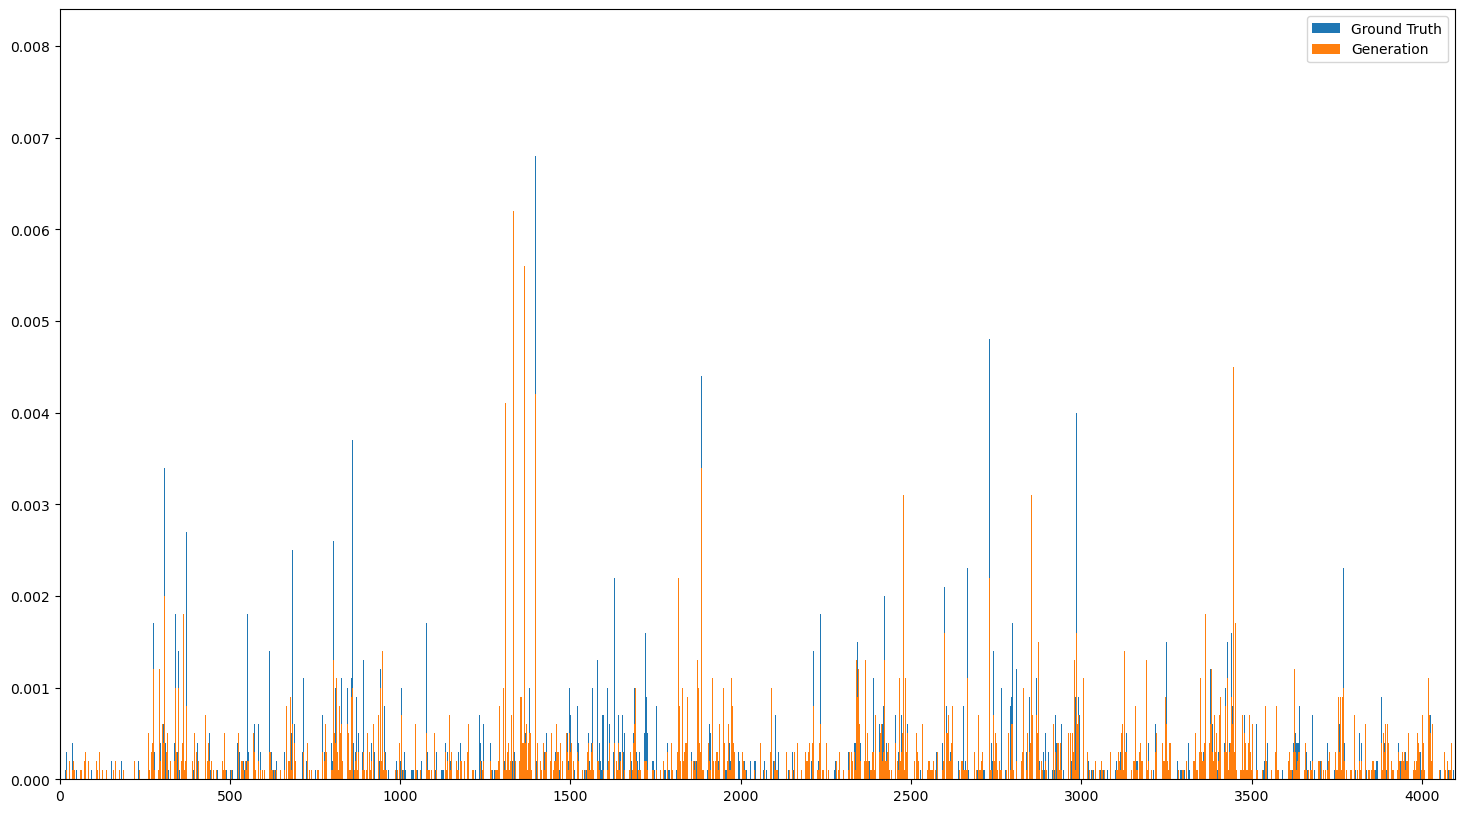

In [1157]:
# visualization (original order)
x_lim = 2**HM.n_d
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d, dist_d,label = "Ground Truth")
ax.bar(values_g,dist_g,label = "Generation")
ax.set(xlim=(0, x_lim))
plt.legend()

In [1158]:
reordered_set = np.append(values_d,np.where(np.in1d(np.arange(0,2**HM.n_d),values_d,invert=True)))
reordered_set

array([   8,   17,   20, ..., 4090, 4092, 4095], dtype=int64)

In [1159]:
xy, g_ind, re_ind = np.intersect1d(values_g, reordered_set, return_indices=True)

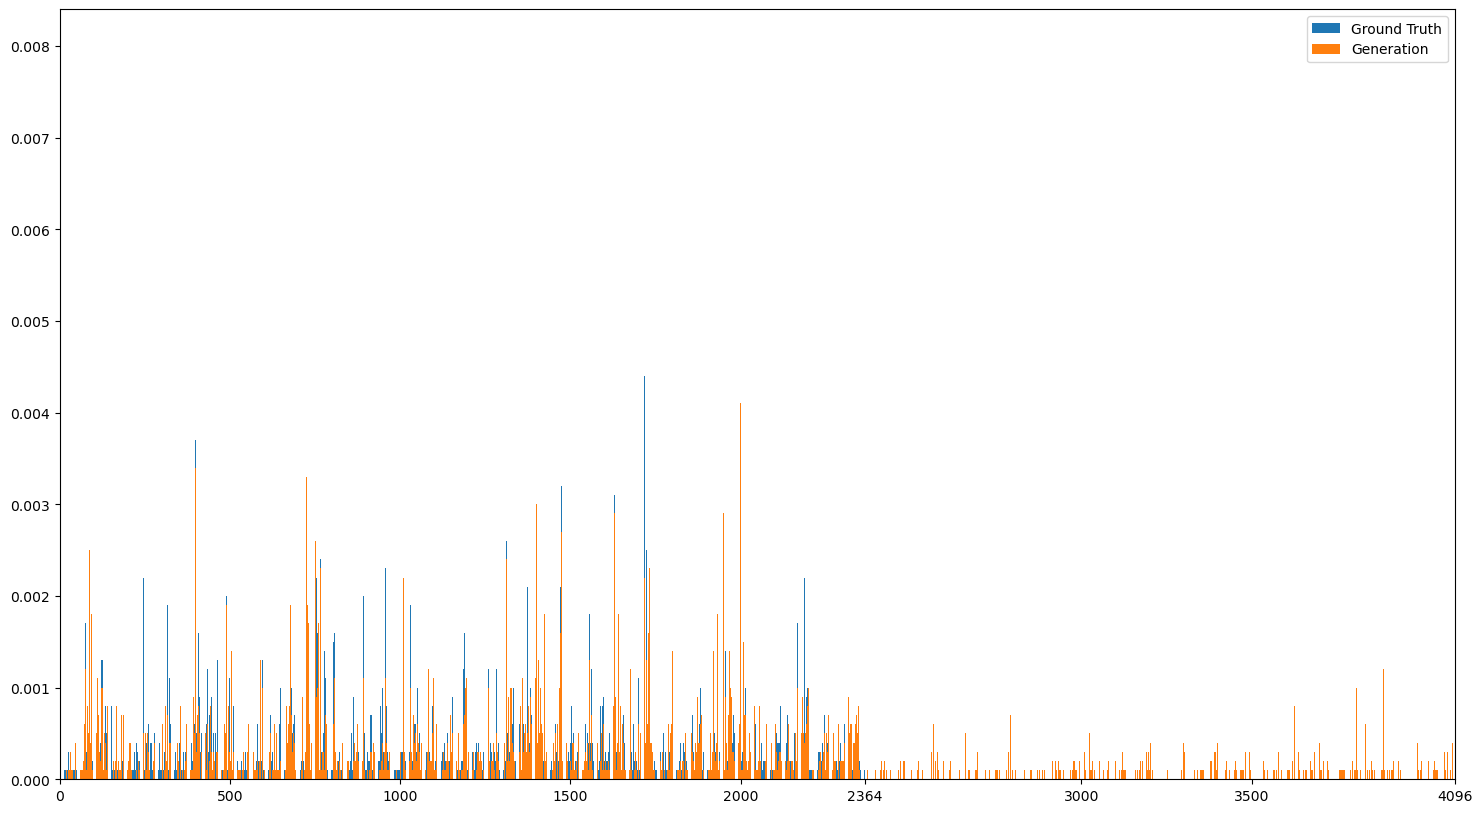

In [1160]:
# visualization (re-order)
x_lim = 2**HM.n_d
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - counts_d.size))] = counts_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(np.arange(counts_d.size),dist_d,label = "Ground Truth")
ax.bar(np.sort(re_ind),dist_g[np.argsort(re_ind)],label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

#### Mutual Information

In [446]:
HM.prob_matrix(data_dist)
HM.Prob_cat_wake

{'Prob_01': array([[9.76562500e-04, 9.76562500e-04, 9.76562500e-04, ...,
         9.76562500e-04, 9.76562500e-04, 6.93147181e+00],
        [6.40662995e-03, 1.56487192e-03, 6.25979709e-03, ...,
         2.67931555e-08, 6.54444803e-09, 4.78841939e+00],
        [2.17838284e-02, 4.43198222e-03, 1.41175962e-02, ...,
         4.69481721e-08, 9.55173995e-09, 5.02377140e+00],
        ...,
        [2.97058984e-01, 2.44997185e-04, 1.30785988e-04, ...,
         9.09079560e-27, 7.49756598e-30, 1.92973739e+00],
        [2.09712418e-01, 4.22465948e-05, 9.02138647e-05, ...,
         2.68396949e-32, 5.40686015e-36, 1.79774299e+00],
        [5.77589697e-03, 2.66826123e-04, 2.12035168e-04, ...,
         5.22976266e-06, 7.80681573e-07, 2.46647812e+00]]),
 'Prob_12': array([[3.90625000e-03, 3.90625000e-03, 3.90625000e-03, ...,
         3.90625000e-03, 3.90625000e-03, 5.54517744e+00],
        [4.33828117e-02, 2.49633735e-02, 8.10792742e-02, ...,
         1.90354056e-05, 1.09533689e-05, 4.26368010e+00],
   

In [228]:
key = 'Prob_01'

In [229]:
# p = HM.Prob_cat_wake[key][-1,:-1]  # categorical probability of this layer
p = HM.Prob_ft_wake[key][-1,:-1]   # factorized probability of this layer
p

array([0.54899936, 0.23878196, 0.43361982, 0.65364778, 0.11177801,
       0.2131588 , 0.08128675, 0.08877533, 0.07838986, 0.07146696])

In [268]:
# H_prev = entropy(HM.Prob_cat_wake[key][-1:,:-1])[0]
H_prev = entropy_bernoulli(HM.Prob_ft_wake[key][-1:,:-1]).sum()
H_prev

4.5496379052138085

In [231]:
def entropy_itr(H_prev,s,a):
    """
    Iterative formula for entropy:
    H_+1 = (s(H-log(s)) + (s+1)log(s+1) + [alog(a) - (a+1)log(a+1)])/(s+1)
    
    Arguments:
    H_prev -- previous entropy
    s -- total counts
    a -- counts for the category being modified
     
    Returns:
    H -- updated entropy
    """
    H = (s*(H_prev-np.log(s)) + (s+1)*np.log(s+1) + [a*np.log(a) - (a+1)*np.log(a+1)])/(s+1)
    return H

In [266]:
entropy_itr(0,1,1)

array([0.])

In [223]:
s = 100
d = 0
for i in range(p.size):
    a = p[i]*s
    diff = entropy_itr(H_prev,s,a) - H_prev
    d += diff
d/p.size

array([-0.03527652])

34: 0.01551925,0.01222263

23: 0.00142507,0.01296877

12: 0.01083906,0.00781174

01: 0.00903954,0.01031023

Base 100, categorical entropy change 0.01 for all layers

In [250]:
s = 300
count = p*s
count

array([164.69980869,  71.63458732, 130.08594482, 196.09433406,
        33.53340158,  63.94763947,  24.38602566,  26.63259969,
        23.51695892,  21.44008756])

In [251]:
comb = binarilize(np.arange(2**count.size),count.size)
comb

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 0, 1]])

In [252]:
p_comb = (count.reshape(-1,1) + comb)/(s+1)
p_comb

array([[0.54717544, 0.54717544, 0.54717544, ..., 0.5504977 , 0.5504977 ,
        0.5504977 ],
       [0.23798866, 0.23798866, 0.23798866, ..., 0.24131092, 0.24131092,
        0.24131092],
       [0.43217922, 0.43217922, 0.43217922, ..., 0.43550148, 0.43550148,
        0.43550148],
       ...,
       [0.0884804 , 0.0884804 , 0.0884804 , ..., 0.09180266, 0.09180266,
        0.09180266],
       [0.07812943, 0.07812943, 0.08145169, ..., 0.07812943, 0.08145169,
        0.08145169],
       [0.07122953, 0.07455179, 0.07122953, ..., 0.07455179, 0.07122953,
        0.07455179]])

In [253]:
entropy_bernoulli(p_comb).sum(axis=0).mean() - H_prev

0.01880876956171562

Factorized entropy +1 with base 100

34: 0.01353517685061778, 0.014576282609702895

23: 0.02094969259531121, 0.004340326260527494

12: 0.027016930883997148, 0.01679027774906583

01: 0.05793475883632837, 0.05497309139037743

In [259]:
ur = 0.05 # update rate
base = 100

In [422]:
def init_base(Prob_ft_wake,Prob_cat_wake,base):
    Count_ft = {}
    Count_cat = {}
    for key in Prob_ft_wake:
        Count_ft[key] = Prob_ft_wake[key][-1,:-1] * base
        Count_ft[key] = np.append(Count_ft[key],base)
        Count_ft[key] = np.append(Count_ft[key],entropy_bernoulli(Prob_ft_wake[key][-1,:-1]))
        
        Count_cat[key] = Prob_cat_wake[key][-1,:-1] * base
        Count_cat[key] = np.append(Count_cat[key],base)
        Count_cat[key] = np.append(Count_cat[key],entropy(Prob_cat_wake[key][-1:,:-1]))
    return Count_ft,Count_cat

In [423]:
Count_ft,Count_cat = init_base(HM.Prob_ft_wake,HM.Prob_cat_wake,base)
Count_ft

{'Prob_01': array([ 54.89993623,  23.87819577,  43.36198161,  65.36477802,
         11.17780053,  21.31587982,   8.12867522,   8.87753323,
          7.83898631,   7.14669585, 100.        ,   0.68833759,
          0.54967184,   0.68430845,   0.64515923,   0.35021662,
          0.51811188,   0.28190087,   0.2996952 ,   0.27481914,
          0.25741709]),
 'Prob_12': array([ 66.10852028,  12.18391613,  26.72407105,  39.57380534,
         31.04852621,  36.17000155,  25.70052392,  31.83021006,
        100.        ,   0.64031304,   0.37057345,   0.58049503,
          0.67124571,   0.61948838,   0.65439006,   0.56990113,
          0.625583  ]),
 'Prob_23': array([ 31.26477724,  49.47404222,  32.15622618,  30.29453617,
         50.11200557,  41.66563225, 100.        ,   0.62120284,
          0.69309185,   0.62804144,   0.61333928,   0.69314467,
          0.67918979]),
 'Prob_34': array([ 24.22896174,  29.7297775 ,   7.7302792 , 100.        ,
          0.55370478,   0.6085573 ,   0.27213192])}

In [435]:
def Mutual_inform(q,Count_ft_arr,Count_cat_arr):
    base = Count_cat_arr[-2]
    n_neuron = q.size
    
    comb = binarilize(np.arange(2**n_neuron),n_neuron)
    count_q = q * base
    q_comb = count_q**comb * (base-count_q)**(1-comb)
    entropy_q = entropy_bernoulli(q) #(n_neuron,1)
    new_entropy_q = entropy_itr(entropy_q,base,q_comb)[0]  #(n_neuron,2**n_neuron)
    
    count_ft = Count_ft_arr[:n_neuron].reshape(-1,1)
    ft_comb = count_ft**comb * (base-count_ft)**(1-comb)
    entropy_ft = Count_ft_arr[-n_neuron:].reshape(-1,1) #(n_neuron,1)
    new_entropy_ft = entropy_itr(entropy_ft,base,ft_comb)[0] #(n_neuron,2**n_neuron)
    
    count_cat = Count_cat_arr[:-2]
    entropy_cat = Count_cat_arr[-1]
    new_entropy_cat = entropy_itr(entropy_cat,base,count_cat)[0] #(2**n_neuron,)
    
    MI = (new_entropy_ft.sum(axis=0) + new_entropy_cat)/2 - new_entropy_q.sum(axis=0) #(2**n_neuron,)
    choice = MI.argmax()
    Count_ft_arr[:n_neuron] += comb[:,choice]
    Count_ft_arr[n_neuron] += 1
    Count_ft_arr[-n_neuron:] = new_entropy_ft[:,choice]
    
    Count_cat_arr[choice] += 1
    Count_cat_arr[-2] += 1
    Count_cat_arr[-1] = new_entropy_cat[choice]
    return [new_entropy_ft.sum(axis=0),new_entropy_cat,new_entropy_q.sum(axis=0),MI],Count_ft_arr,Count_cat_arr

In [436]:
q = np.random.rand(3,1)
q

array([[0.32626378],
       [0.95672509],
       [0.03167473]])

In [437]:
Count_ft_arr = Count_ft['Prob_34']
Count_cat_arr = Count_cat['Prob_34']

In [438]:
base = Count_cat_arr[-2]
n_neuron = q.size

comb = binarilize(np.arange(2**n_neuron),n_neuron)
count_q = q * base
q_comb = count_q**comb * (base-count_q)**(1-comb)
entropy_q = entropy_bernoulli(q) #(n_neuron,1)
new_entropy_q = entropy_itr(entropy_q,base,q_comb)  #(n_neuron,2**n_neuron)
new_entropy_q

array([[[0.62915831, 0.62915831, 0.62915831, 0.62915831, 0.63619186,
         0.63619186, 0.63619186, 0.63619186],
        [0.2062585 , 0.2062585 , 0.17690018, 0.17690018, 0.2062585 ,
         0.2062585 , 0.17690018, 0.17690018],
        [0.13945271, 0.17163887, 0.13945271, 0.17163887, 0.13945271,
         0.17163887, 0.13945271, 0.17163887]]])

In [439]:
count_ft = Count_ft_arr[:n_neuron].reshape(-1,1)
ft_comb = count_ft**comb * (base-count_ft)**(1-comb)
entropy_ft = Count_ft_arr[-n_neuron:].reshape(-1,1) #(n_neuron,1)
new_entropy_ft = entropy_itr(entropy_ft,base,ft_comb) #(n_neuron,2**n_neuron)
new_entropy_ft

array([[[0.559397  , 0.559397  , 0.559397  , 0.559397  , 0.57005123,
         0.57005123, 0.57005123, 0.57005123],
        [0.61193849, 0.61193849, 0.61995909, 0.61995909, 0.61193849,
         0.61193849, 0.61995909, 0.61995909],
        [0.26835733, 0.29221647, 0.26835733, 0.29221647, 0.26835733,
         0.29221647, 0.26835733, 0.29221647]]])

In [442]:
entropy_bernoulli((count_ft + comb)/(base+1))

array([[0.559397  , 0.559397  , 0.559397  , 0.559397  , 0.57005123,
        0.57005123, 0.57005123, 0.57005123],
       [0.61193849, 0.61193849, 0.61995909, 0.61995909, 0.61193849,
        0.61193849, 0.61995909, 0.61995909],
       [0.26835733, 0.29221647, 0.26835733, 0.29221647, 0.26835733,
        0.29221647, 0.26835733, 0.29221647]])

In [369]:
count_cat = Count_cat_arr[:-2]
entropy_cat = Count_cat_arr[-1]
new_entropy_cat = entropy_itr(entropy_cat,base,count_cat) #(2**n_neuron,)
new_entropy_cat

array([[1.425234  , 1.44984113, 1.43413311, 1.45671968, 1.43710094,
        1.45746599, 1.44409663, 1.46111183]])

In [331]:
new_entropy_ft[0].sum(axis=0)

masked_array(data=[1.4271884045666865, 1.451177625588427,
                   1.435610663545397, 1.4595998845671374,
                   1.4383406736179039, 1.4623298946396444,
                   1.4467629325966138, 1.4707521536183545],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

In [405]:
new_entropy_q.shape

(1, 3, 8)

In [403]:
MI = (new_entropy_ft[0].sum(axis=0) + new_entropy_cat)/2 - new_entropy_q[0].sum(axis=0)
MI

array([[0.01555497, 0.0090099 , 0.03334331, 0.02578795, 0.03390484,
        0.02523872, 0.05074146, 0.04040042]])

In [404]:
MI.argmax()

6

In [443]:
MI_,Count_ft_arr,Count_cat_arr = Mutual_inform(q,Count_ft['Prob_34'],Count_cat['Prob_34'])

In [444]:
def check_M(n_neuron,Count_ft_arr,Count_cat_arr):
    check1 = Count_cat_arr[:-2].sum() - Count_cat_arr[-2]
    check2 = Count_ft_arr[n_neuron] - Count_cat_arr[-2]
    check3 = entropy(Count_cat_arr[:-2].reshape(1,-1)) - Count_cat_arr[-1]
    check4 = (entropy_bernoulli(Count_ft_arr[:n_neuron]/Count_ft_arr[n_neuron]) - Count_ft_arr[-n_neuron:]).mean()
    return [check1,check2,check3,check4]

In [445]:
check_M(3,Count_ft_arr,Count_cat_arr)

[2.842170943040401e-14, 0.0, array([1.55431223e-15]), 1.4802973661668755e-15]

In [289]:
comb = binarilize(np.arange(2**q.size),q.size)
comb

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]])

In [428]:
count_q = q * base
count_q

array([[66.78149883],
       [71.7573143 ],
       [ 4.06544106]])

In [429]:
q_comb = count_q**comb * (100-count_q)**(1-comb)
q_comb

array([[33.21850117, 33.21850117, 33.21850117, 33.21850117, 66.78149883,
        66.78149883, 66.78149883, 66.78149883],
       [28.2426857 , 28.2426857 , 71.7573143 , 71.7573143 , 28.2426857 ,
        28.2426857 , 71.7573143 , 71.7573143 ],
       [95.93455894,  4.06544106, 95.93455894,  4.06544106, 95.93455894,
         4.06544106, 95.93455894,  4.06544106]])

In [430]:
entropy_q = entropy_bernoulli(q)
entropy_q

array([[0.63571524],
       [0.59523081],
       [0.17001835]])

In [431]:
entropy_itr(entropy_q,base,q_comb)

array([[[0.64023434, 0.64023434, 0.64023434, 0.64023434, 0.63339408,
         0.63339408, 0.63339408, 0.63339408],
        [0.6017317 , 0.6017317 , 0.59260405, 0.59260405, 0.6017317 ,
         0.6017317 , 0.59260405, 0.59260405],
        [0.16874385, 0.19896515, 0.16874385, 0.19896515, 0.16874385,
         0.19896515, 0.16874385, 0.19896515]]])

In [432]:
entropy_bernoulli((q*base+comb)/101)

array([[0.64023434, 0.64023434, 0.64023434, 0.64023434, 0.63339408,
        0.63339408, 0.63339408, 0.63339408],
       [0.6017317 , 0.6017317 , 0.59260405, 0.59260405, 0.6017317 ,
        0.6017317 , 0.59260405, 0.59260405],
       [0.16874385, 0.19896515, 0.16874385, 0.19896515, 0.16874385,
        0.19896515, 0.16874385, 0.19896515]])

In [434]:
(entropy_itr(entropy_q,base,q_comb)-entropy_bernoulli((q*base+comb)/101)).mean()

-1.295260195396016e-16

#### Mutual Information Summary

In [967]:
HM.prob_matrix(data_dist)

In [448]:
def entropy_itr(H_prev,s,a):
    """
    Iterative formula for entropy:
    H_+1 = (s(H-log(s)) + (s+1)log(s+1) + [alog(a) - (a+1)log(a+1)])/(s+1)
    
    Arguments:
    H_prev -- previous entropy
    s -- total counts
    a -- counts for the category being modified
     
    Returns:
    H -- updated entropy
    """
    H = (s*(H_prev-np.log(s)) + (s+1)*np.log(s+1) + [a*np.log(a) - (a+1)*np.log(a+1)])/(s+1)
    return H

In [449]:
def init_base(Prob_ft_wake,Prob_cat_wake,base=100):
    Count_ft = {}
    Count_cat = {}
    for key in Prob_ft_wake:
        Count_ft[key] = Prob_ft_wake[key][-1,:-1] * base
        Count_ft[key] = np.append(Count_ft[key],base)
        Count_ft[key] = np.append(Count_ft[key],entropy_bernoulli(Prob_ft_wake[key][-1,:-1]))
        
        Count_cat[key] = Prob_cat_wake[key][-1,:-1] * base
        Count_cat[key] = np.append(Count_cat[key],base)
        Count_cat[key] = np.append(Count_cat[key],entropy(Prob_cat_wake[key][-1:,:-1]))
    return Count_ft,Count_cat

In [450]:
Count_ft,Count_cat = init_base(HM.Prob_ft_wake,HM.Prob_cat_wake,base=100)

In [481]:
def Mutual_inform(q,Count_ft_arr,Count_cat_arr):
    base = Count_cat_arr[-2]
    n_neuron = q.size
    
    comb = binarilize(np.arange(2**n_neuron),n_neuron)
    count_q = q * base
    q_comb = count_q**comb * (base-count_q)**(1-comb)
    entropy_q = entropy_bernoulli(q) #(n_neuron,1)
    new_entropy_q = entropy_itr(entropy_q,base,q_comb)[0]  #(n_neuron,2**n_neuron)
    
    count_ft = Count_ft_arr[:n_neuron].reshape(-1,1)
    ft_comb = count_ft**comb * (base-count_ft)**(1-comb)
    entropy_ft = Count_ft_arr[-n_neuron:].reshape(-1,1) #(n_neuron,1)
    new_entropy_ft = entropy_itr(entropy_ft,base,ft_comb)[0] #(n_neuron,2**n_neuron)
    
    count_cat = Count_cat_arr[:-2]
    entropy_cat = Count_cat_arr[-1]
    new_entropy_cat = entropy_itr(entropy_cat,base,count_cat)[0] #(2**n_neuron,)
    
    MI = (new_entropy_ft.sum(axis=0) + new_entropy_cat)/2 - new_entropy_q.sum(axis=0) #(2**n_neuron,)
    choice = MI.argmax()
    # update count matrices
    Count_ft_arr[:n_neuron] += comb[:,choice]
    Count_ft_arr[n_neuron] += 1
    Count_ft_arr[-n_neuron:] = new_entropy_ft[:,choice]
    
    Count_cat_arr[choice] += 1
    Count_cat_arr[-2] += 1
    Count_cat_arr[-1] = new_entropy_cat[choice]
    
    sample = comb[:,choice:choice+1]
    # return [new_entropy_ft.sum(axis=0),new_entropy_cat,new_entropy_q.sum(axis=0),MI]
    return sample

In [482]:
q = np.random.rand(3,1)
q

array([[0.90760582],
       [0.34271788],
       [0.81738018]])

In [485]:
Mutual_inform(q,Count_ft['Prob_34'],Count_cat['Prob_34'])

array([[1],
       [0],
       [1]])

In [487]:
Count_ft

{'Prob_01': array([ 54.89993623,  23.87819577,  43.36198161,  65.36477802,
         11.17780053,  21.31587982,   8.12867522,   8.87753323,
          7.83898631,   7.14669585, 100.        ,   0.68833759,
          0.54967184,   0.68430845,   0.64515923,   0.35021662,
          0.51811188,   0.28190087,   0.2996952 ,   0.27481914,
          0.25741709]),
 'Prob_12': array([ 66.10852028,  12.18391613,  26.72407105,  39.57380534,
         31.04852621,  36.17000155,  25.70052392,  31.83021006,
        100.        ,   0.64031304,   0.37057345,   0.58049503,
          0.67124571,   0.61948838,   0.65439006,   0.56990113,
          0.625583  ]),
 'Prob_23': array([ 31.26477724,  49.47404222,  32.15622618,  30.29453617,
         50.11200557,  41.66563225, 100.        ,   0.62120284,
          0.69309185,   0.62804144,   0.61333928,   0.69314467,
          0.67918979]),
 'Prob_34': array([ 42.22896174,  39.7297775 ,  24.7302792 , 119.        ,
          0.65040649,   0.63688114,   0.51105059])}

In [463]:
def check_M(n_neuron,Count_ft_arr,Count_cat_arr):
    check1 = Count_cat_arr[:-2].sum() - Count_cat_arr[-2]
    check2 = Count_ft_arr[n_neuron] - Count_cat_arr[-2]
    check3 = entropy(Count_cat_arr[:-2].reshape(1,-1)) - Count_cat_arr[-1]
    check4 = (entropy_bernoulli(Count_ft_arr[:n_neuron]/Count_ft_arr[n_neuron]) - Count_ft_arr[-n_neuron:]).mean()
    return [check1,check2,check3,check4]

In [454]:
check_M(3,Count_ft_arr,Count_cat_arr)

[2.842170943040401e-14, 0.0, array([8.8817842e-16]), 6.291263806209221e-16]

In [999]:
epoch = 500
add_norm = False

In [1000]:
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(HM.n_layer)
    Loss_P_total = np.zeros(HM.n_layer)
    
    if e>0 and e % 5 == 0:
        HM.prob_matrix(data_dist)
        Count_ft,Count_cat = init_base(HM.Prob_ft_wake,HM.Prob_cat_wake,base=100)
        c = 0
        for i in range(n_data):
            d0 = dataset[:,index[i]:index[i]+1]
            Alpha_Q = HM.MI_wake_sample(d0,Count_ft,Count_cat,add_norm)
            Loss_P,Grad_P = HM.sleep_update(Alpha_Q,add_norm)
            Loss_Q,Grad_Q = HM.wake_update(Alpha_Q,add_norm)
            
            Loss_Q_total += Loss_Q
            Loss_P_total += Loss_P
            
            c += 1
            if c % 100 == 0:
                HM.prob_matrix(data_dist)
                Count_ft,Count_cat = init_base(HM.Prob_ft_wake,HM.Prob_cat_wake,base=100)
                c = 0
    else:
        for i in range(n_data):  
            d0 = dataset[:,index[i]:index[i]+1]
            Alpha_Q = HM.wake_sample(d0,add_norm)
            Loss_P,Grad_P = HM.sleep_update(Alpha_Q,add_norm)
            Alpha_P = HM.sleep_sample(add_norm)
            Loss_Q,Grad_Q = HM.wake_update(Alpha_P,add_norm)
            
            Loss_Q_total += Loss_Q
            Loss_P_total += Loss_P
            
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))
HM.check_learning_rate(Alpha_P,Alpha_Q)

Loss_Q: [1.62 1.6  0.44 0.   3.66] Loss_P: [ 5.9   1.78  1.68  1.05 10.4 ]
Loss_Q: [1.55 1.43 0.47 0.   3.44] Loss_P: [ 5.76  1.78  1.54  1.26 10.34]
Loss_Q: [1.57 1.5  0.51 0.   3.58] Loss_P: [ 5.9   1.78  1.6   1.14 10.41]
Loss_Q: [1.51 1.58 0.61 0.   3.7 ] Loss_P: [ 6.11  1.66  1.7   1.27 10.75]
Loss_Q: [1.65 1.81 0.61 0.   4.06] Loss_P: [ 6.05  1.69  2.07  1.29 11.09]
Loss_Q: [1.33 1.   0.43 0.   2.76] Loss_P: [ 4.07  2.61  2.14  1.93 10.74]
Loss_Q: [2.19 1.78 0.8  0.   4.77] Loss_P: [ 4.24  3.01  2.48  1.78 11.51]
Loss_Q: [2.28 1.98 0.79 0.   5.04] Loss_P: [ 4.79  2.85  2.49  1.72 11.85]
Loss_Q: [2.35 1.97 0.64 0.   4.96] Loss_P: [ 4.96  2.81  2.41  1.67 11.86]
Loss_Q: [2.32 1.93 0.63 0.   4.88] Loss_P: [ 5.24  2.66  2.52  1.44 11.86]
Loss_Q: [1.07 0.73 0.37 0.   2.16] Loss_P: [ 3.33  2.41  2.43  1.92 10.08]
Loss_Q: [2.15 1.8  0.84 0.   4.8 ] Loss_P: [ 3.92  2.85  2.82  1.79 11.38]
Loss_Q: [2.29 1.75 0.7  0.   4.75] Loss_P: [ 4.41  2.69  2.77  1.68 11.54]
Loss_Q: [2.37 1.82 0.78 0

Loss_Q: [1.92 1.4  0.75 0.   4.06] Loss_P: [ 3.47  2.6   3.11  1.54 10.72]
Loss_Q: [2.35 1.84 0.67 0.   4.86] Loss_P: [ 4.11  2.95  3.15  1.5  11.71]
Loss_Q: [2.56 2.09 0.75 0.   5.4 ] Loss_P: [ 4.48  3.22  3.    1.64 12.34]
Loss_Q: [2.8  2.21 0.82 0.   5.84] Loss_P: [ 4.84  3.4   2.82  1.7  12.77]
Loss_Q: [0.64 0.4  0.21 0.   1.24] Loss_P: [2.4  2.08 2.76 1.75 8.99]
Loss_Q: [1.81 1.26 0.8  0.   3.87] Loss_P: [ 3.12  2.52  3.02  1.58 10.25]
Loss_Q: [2.19 1.61 0.69 0.   4.49] Loss_P: [ 4.02  2.77  3.22  1.42 11.43]
Loss_Q: [2.69 2.02 0.63 0.   5.34] Loss_P: [ 4.67  2.89  3.2   1.42 12.18]
Loss_Q: [2.77 2.38 0.64 0.   5.79] Loss_P: [ 5.03  3.05  3.32  1.33 12.73]
Loss_Q: [0.7  0.32 0.27 0.   1.29] Loss_P: [2.49 2.01 2.75 1.76 9.  ]
Loss_Q: [1.95 1.49 0.74 0.   4.18] Loss_P: [ 3.33  2.53  3.15  1.48 10.49]
Loss_Q: [2.15 1.64 0.6  0.   4.39] Loss_P: [ 3.83  2.88  3.22  1.37 11.3 ]
Loss_Q: [2.54 2.13 0.65 0.   5.32] Loss_P: [ 4.51  3.14  3.22  1.43 12.3 ]
Loss_Q: [2.72 2.21 0.65 0.   5.59] 

Loss_Q: [2.38 1.81 0.73 0.   4.92] Loss_P: [ 4.02  2.95  3.05  1.62 11.65]
Loss_Q: [2.67 2.24 0.72 0.   5.64] Loss_P: [ 4.94  2.92  3.27  1.51 12.64]
Loss_Q: [2.81 2.43 0.71 0.   5.96] Loss_P: [ 5.27  2.89  3.25  1.47 12.87]
Loss_Q: [0.73 0.35 0.19 0.   1.27] Loss_P: [2.49 2.01 2.84 1.69 9.03]
Loss_Q: [1.75 1.52 0.78 0.   4.05] Loss_P: [ 3.22  2.64  2.98  1.63 10.46]
Loss_Q: [2.38 1.76 0.75 0.   4.9 ] Loss_P: [ 4.12  3.05  3.29  1.44 11.9 ]
Loss_Q: [2.54 2.03 0.75 0.   5.32] Loss_P: [ 4.44  3.07  3.31  1.41 12.23]
Loss_Q: [2.82 2.35 0.79 0.   5.95] Loss_P: [ 4.82  3.17  3.35  1.4  12.74]
Loss_Q: [0.74 0.39 0.23 0.   1.36] Loss_P: [2.53 1.99 2.9  1.71 9.12]
Loss_Q: [1.73 1.51 0.78 0.   4.03] Loss_P: [ 3.1   2.73  2.91  1.63 10.37]
Loss_Q: [2.1  1.8  0.71 0.   4.62] Loss_P: [ 3.8   3.07  3.04  1.62 11.52]
Loss_Q: [2.7  2.25 0.67 0.   5.62] Loss_P: [ 4.73  2.95  3.18  1.45 12.32]
Loss_Q: [2.87 2.68 0.7  0.   6.26] Loss_P: [ 5.47  3.02  3.24  1.46 13.18]
Loss_Q: [0.79 0.41 0.2  0.   1.41] 

Loss_Q: [2.63 2.19 0.69 0.   5.5 ] Loss_P: [ 4.76  3.14  3.1   1.59 12.58]
Loss_Q: [2.95 2.54 0.72 0.   6.22] Loss_P: [ 5.38  3.06  3.15  1.55 13.13]
Loss_Q: [0.74 0.36 0.2  0.   1.31] Loss_P: [2.46 2.16 2.64 1.78 9.04]
Loss_Q: [1.74 1.42 0.65 0.   3.82] Loss_P: [ 3.17  2.74  2.82  1.64 10.36]
Loss_Q: [2.22 1.71 0.7  0.   4.63] Loss_P: [ 3.83  3.3   2.77  1.65 11.56]
Loss_Q: [2.61 1.94 0.68 0.   5.23] Loss_P: [ 4.42  3.22  2.9   1.58 12.12]
Loss_Q: [2.82 2.19 0.66 0.   5.68] Loss_P: [ 4.86  3.24  3.11  1.48 12.69]
Loss_Q: [0.73 0.28 0.22 0.   1.23] Loss_P: [2.43 2.1  2.65 1.76 8.94]
Loss_Q: [1.6  1.43 0.74 0.   3.77] Loss_P: [ 3.14  2.74  2.82  1.64 10.34]
Loss_Q: [2.19 1.67 0.7  0.   4.56] Loss_P: [ 3.82  3.03  2.97  1.58 11.41]
Loss_Q: [2.72 2.19 0.73 0.   5.64] Loss_P: [ 4.74  3.31  3.09  1.56 12.71]
Loss_Q: [2.97 2.42 0.69 0.   6.08] Loss_P: [ 5.05  3.17  3.27  1.41 12.9 ]
Loss_Q: [0.75 0.35 0.2  0.   1.3 ] Loss_P: [2.47 2.06 2.75 1.74 9.03]
Loss_Q: [1.8  1.31 0.72 0.   3.83] Loss_

Loss_Q: [2.84 2.33 0.81 0.   5.98] Loss_P: [ 4.8   3.33  3.05  1.57 12.74]
Loss_Q: [0.7  0.35 0.21 0.   1.26] Loss_P: [2.37 2.07 2.77 1.75 8.96]
Loss_Q: [1.62 1.43 0.75 0.   3.81] Loss_P: [ 3.2   2.73  3.01  1.59 10.52]
Loss_Q: [2.12 1.8  0.71 0.   4.63] Loss_P: [ 3.91  3.21  3.01  1.6  11.73]
Loss_Q: [2.62 2.13 0.71 0.   5.46] Loss_P: [ 4.5   3.19  3.18  1.48 12.36]
Loss_Q: [2.9  2.33 0.71 0.   5.94] Loss_P: [ 5.25  2.9   3.42  1.29 12.86]
Loss_Q: [0.75 0.33 0.23 0.   1.31] Loss_P: [2.41 2.11 2.82 1.73 9.07]
Loss_Q: [1.61 1.35 0.75 0.   3.71] Loss_P: [ 3.    2.56  3.06  1.51 10.14]
Loss_Q: [2.24 1.72 0.65 0.   4.62] Loss_P: [ 3.93  2.99  3.2   1.35 11.47]
Loss_Q: [2.51 1.98 0.69 0.   5.18] Loss_P: [ 4.43  3.09  3.2   1.41 12.13]
Loss_Q: [2.82 2.23 0.68 0.   5.72] Loss_P: [ 4.89  3.03  3.37  1.28 12.57]
Loss_Q: [0.68 0.31 0.21 0.   1.2 ] Loss_P: [2.39 2.1  2.72 1.76 8.96]
Loss_Q: [1.56 1.49 0.78 0.   3.84] Loss_P: [ 3.1   2.73  2.83  1.7  10.36]
Loss_Q: [2.28 1.78 0.67 0.   4.73] Loss_

In [859]:
Count_ft

{'Prob_01': array([ 43.07148843,  47.61834263,  65.48284013,  46.15759739,
         50.67524855,  45.89181787,  43.71077623,  55.49952632,
        100.        ,   0.68351536,   0.69201229,   0.64440632,
          0.69019146,   0.69305599,   0.68976794,   0.68521532,
          0.68708597]),
 'Prob_12': array([ 33.61019477,  43.9792131 ,  30.62607299,  36.86180876,
         54.8340931 ,  48.31780781, 100.        ,   0.638416  ,
          0.68587958,   0.61607605,   0.65821611,   0.68846618,
          0.69258112]),
 'Prob_23': array([ 41.84468604,  64.55375643,  43.90932605, 100.        ,
          0.67978574,   0.65016538,   0.68570946])}

In [860]:
Count_cat

{'Prob_01': array([5.51645608e-03, 3.24380283e-02, 2.59094598e-02, 7.68773094e-02,
        4.38157545e-02, 2.45520582e-01, 1.30311909e-01, 3.36690303e-01,
        8.48725993e-03, 1.00615694e-01, 5.00753321e-02, 2.27330636e-01,
        6.11562356e-02, 3.16019793e-01, 1.25054320e-01, 7.03414589e-01,
        1.52271655e-02, 1.37427611e-01, 9.89631833e-02, 3.30452567e-01,
        1.29109178e-01, 8.03103617e-01, 3.32173870e-01, 6.35652994e-01,
        2.54020709e-02, 3.32490649e-01, 1.39752240e-01, 5.87991489e-01,
        1.81771190e-01, 1.06998839e+00, 2.95133300e-01, 8.10315473e-01,
        1.01347043e-01, 1.23432106e+00, 4.40271855e-01, 1.29353106e+00,
        1.60940916e-01, 1.84940168e+00, 5.76131281e-01, 1.10711444e+00,
        9.49942774e-02, 7.19525337e-01, 3.57513393e-01, 1.65891297e+00,
        1.43198901e-01, 1.08435799e+00, 1.24525933e-01, 6.16442775e-01,
        1.00428852e-01, 6.00014745e-01, 3.00770986e-01, 8.00004685e-01,
        1.83698648e-01, 9.88064447e-01, 3.86390039e-0

In [863]:
check_M(3,Count_ft['Prob_23'],Count_cat['Prob_23'])

[1.4210854715202004e-14, 0.0, array([0.]), 0.0]

#### Post-processing

In [1001]:
HM.prob_matrix(data_dist)

In [123]:
# HM.Prob_ft_wake

In [124]:
# HM.Prob_cat_wake

In [756]:
def bernoulli_to_cat(p):
    """
    Convert independent multi-variate Bernoulli probability to its counterpart categorical probabilities of all comninations 2**n_p
    Arguments:
    p -- numpy array of bernoulli probabilities p(x=1), of shape (n_p, )
    Returns:
    p_cat -- categorical probability, of shape (2**n_p, )
    """
    n_p = len(p)
    comb = binarilize(np.arange(2**n_p),n_p) #(n_p,2**n_p)
    p = p.reshape(-1,1)
    p_cat = np.prod(p**comb * (1-p)**(1-comb),axis=0)
    
    return p_cat

In [1002]:
for key in HM.Prob_ft_wake:
#     print((HM.Prob_ft_wake[key][:,-1]-HM.Prob_cat_wake[key][:,-1]).sum())
#     q = HM.Prob_ft_wake[key][-1,:-1]
#     print(key,bernoulli_to_cat(q))
#     print(key,HM.Prob_cat_wake[key][-1,:-1])  # not equal

    # categorical
    print(key,'H(Y|X)',HM.Prob_cat_wake[key][-1,-1])
    print(key,'H(Y)',entropy(HM.Prob_cat_wake[key][-1:,:-1]))
    
    # multi-variate Bernoulli
    print(key,'H(Y|X)',HM.Prob_ft_wake[key][-1,-1])
    print(key,'H(Y)',entropy_bernoulli(HM.Prob_ft_wake[key][-1,:-1]).sum())    # H(Y) not equal

Prob_01 H(Y|X) 2.4251367841181173
Prob_01 H(Y) [4.12391012]
Prob_01 H(Y|X) 2.4251367841181173
Prob_01 H(Y) 4.19919656116626
Prob_12 H(Y|X) 2.5793884895564756
Prob_12 H(Y) [3.99275542]
Prob_12 H(Y|X) 2.579388489556475
Prob_12 H(Y) 4.048481700207032
Prob_23 H(Y|X) 0.6564339673231744
Prob_23 H(Y) [1.33359434]
Prob_23 H(Y|X) 0.6564339673231744
Prob_23 H(Y) 1.3368923328209736


Categorical distribution cannot be derived from statistics of independent components.

In [926]:
HM.Theta

{'Theta_10': {'Theta_10': array([[-1.12836791e+01,  1.02398815e+00,  3.35778047e-01,
           3.53290746e-01,  8.95066496e-01, -8.75128118e-01,
          -3.70945638e-02,  9.84799751e-01,  0.00000000e+00,
           1.00000000e+00],
         [ 1.49204337e-01,  1.27435606e+00,  1.68715217e-01,
          -1.16930014e-01,  4.83087540e-01, -3.96008547e-01,
          -1.11366470e+01,  1.47646972e+00,  0.00000000e+00,
           1.00000000e+00],
         [-2.50979396e-01,  7.46475153e-01, -1.07021840e+01,
          -3.48762614e-01,  3.88225305e-01, -4.01664447e-01,
           9.06067755e-02,  1.42687671e+00,  0.00000000e+00,
           1.00000000e+00],
         [-1.41974601e+00,  6.85248093e+00, -9.15917156e-01,
          -1.75800228e+00, -1.35994273e+00, -7.29164364e-01,
          -1.21413123e+00, -8.37469075e+00,  0.00000000e+00,
           1.00000000e+00],
         [-5.84428472e-01, -1.94516931e+00, -9.50359128e-01,
          -1.37552819e+00, -1.06448485e+00,  5.30569889e+00,
          

#### Visualization

In [692]:
HM.prob_matrix(data_dist)

In [693]:
HM.Prob_cat_sleep

{'Prob_43': array([[0.41979283, 0.05427514, 0.1862548 , 0.02408094, 0.19357736,
         0.02502767, 0.08588692, 0.01110434, 1.59624773],
        [0.41979283, 0.05427514, 0.1862548 , 0.02408094, 0.19357736,
         0.02502767, 0.08588692, 0.01110434, 1.59624773]]),
 'Prob_32': array([[1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.56250000e-02,
         1.56250000e-02, 1.56250000e-02, 1.56250000e-02, 1.562500

In [851]:
HM.Prob_cat_sleep['Prob_54']

KeyError: 'Prob_54'

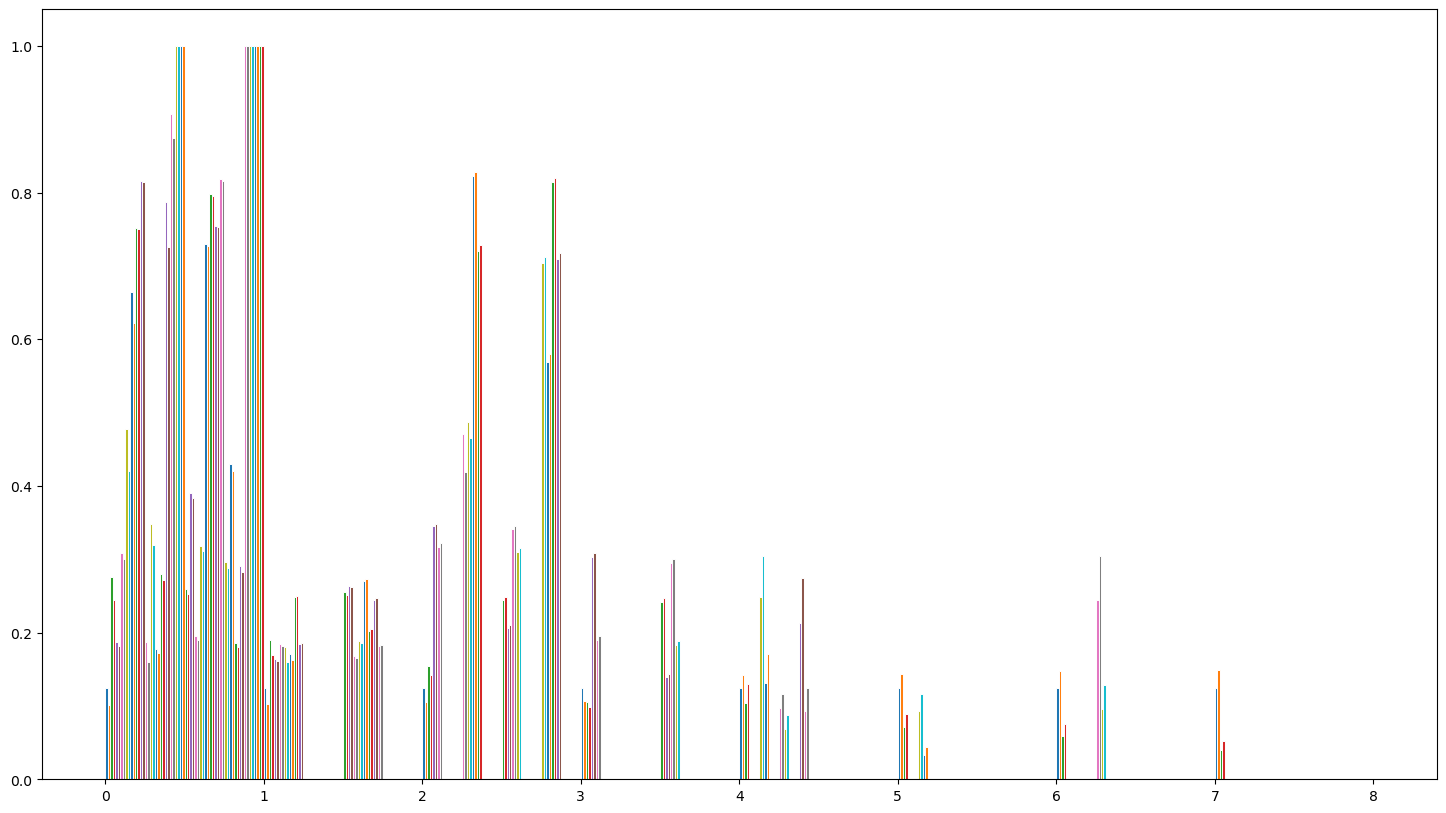

In [927]:
fig, ax = plt.subplots(figsize=(18, 10))
prob_mtx = HM.Prob_cat_wake['Prob_23'][:-1,:-1]
x_size = prob_mtx.shape[0]
y_size = prob_mtx.shape[1]
for i in range(x_size):
    ax.bar(np.arange(y_size)+i/x_size, prob_mtx[i,:], width=1/x_size, edgecolor="white", linewidth=0.7,align='edge')
plt.show()

KeyError: 'Prob_34'

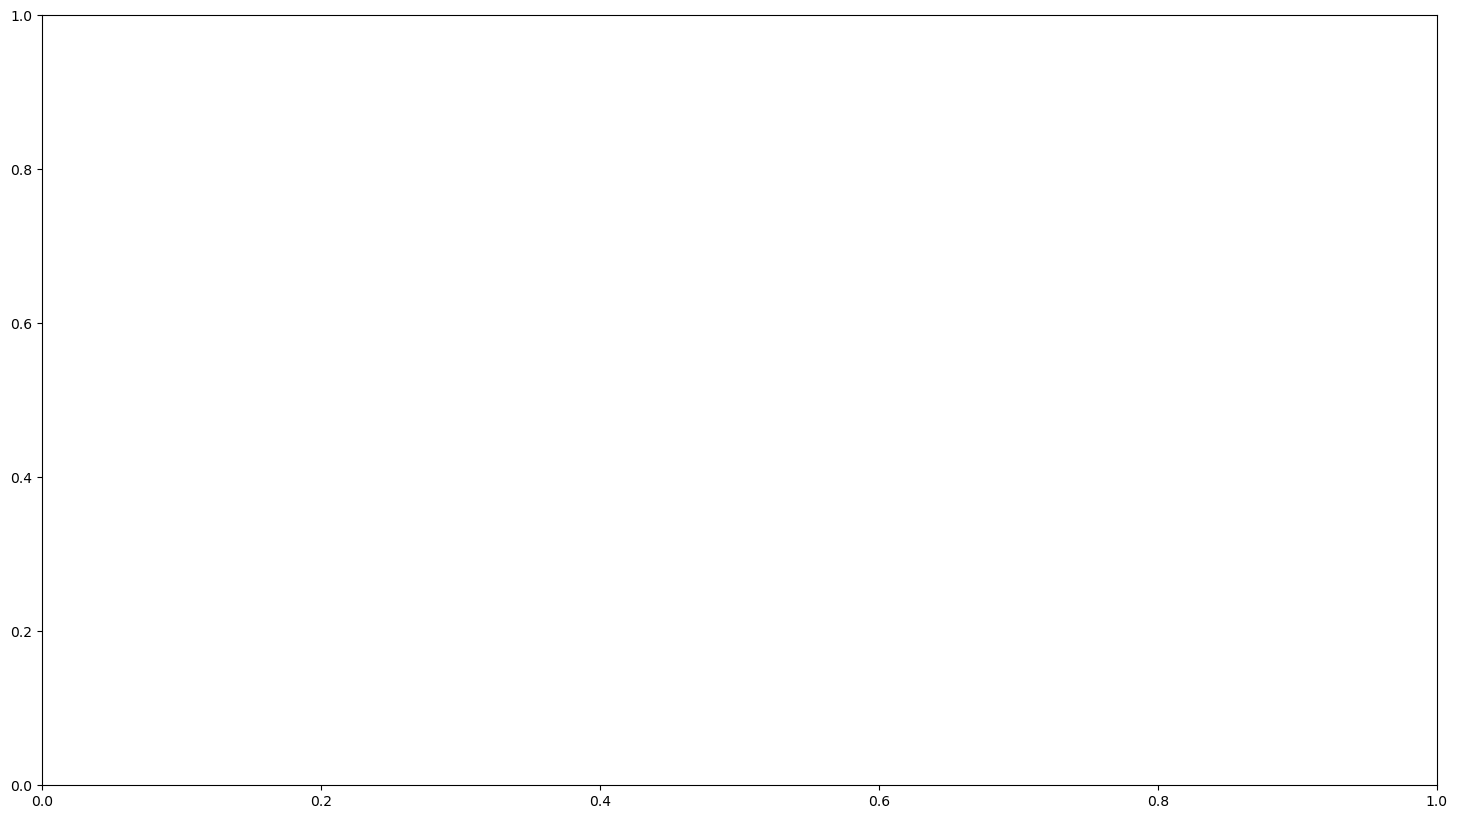

In [697]:
fig, ax = plt.subplots(figsize=(18, 10))
prob_mtx = HM.Prob_cat_wake['Prob_34'][-1:,:-1]
x_size = prob_mtx.shape[0]
y_size = prob_mtx.shape[1]
for i in range(x_size):
    ax.bar(np.arange(y_size)+i/x_size, prob_mtx[i,:], width=1/x_size, edgecolor="white", linewidth=0.7,align='edge')
plt.show()

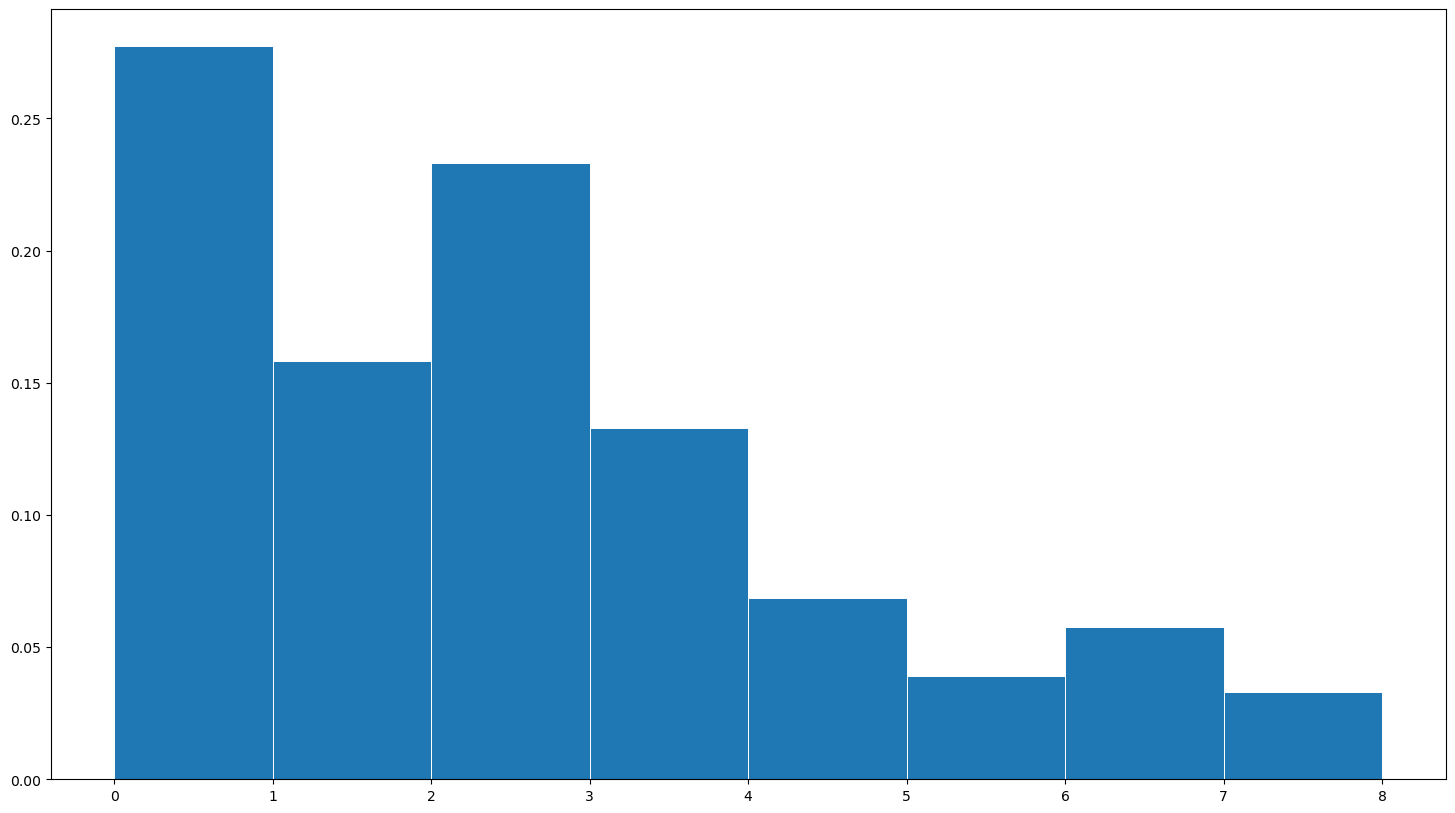

In [632]:
fig, ax = plt.subplots(figsize=(18, 10))
prob_mtx = HM.Prob_cat_sleep['Prob_54'][-1:,:-1]
x_size = prob_mtx.shape[0]
y_size = prob_mtx.shape[1]
for i in range(x_size):
    ax.bar(np.arange(y_size)+i/x_size, prob_mtx[i,:], width=1/x_size, edgecolor="white", linewidth=0.7,align='edge')
plt.show()

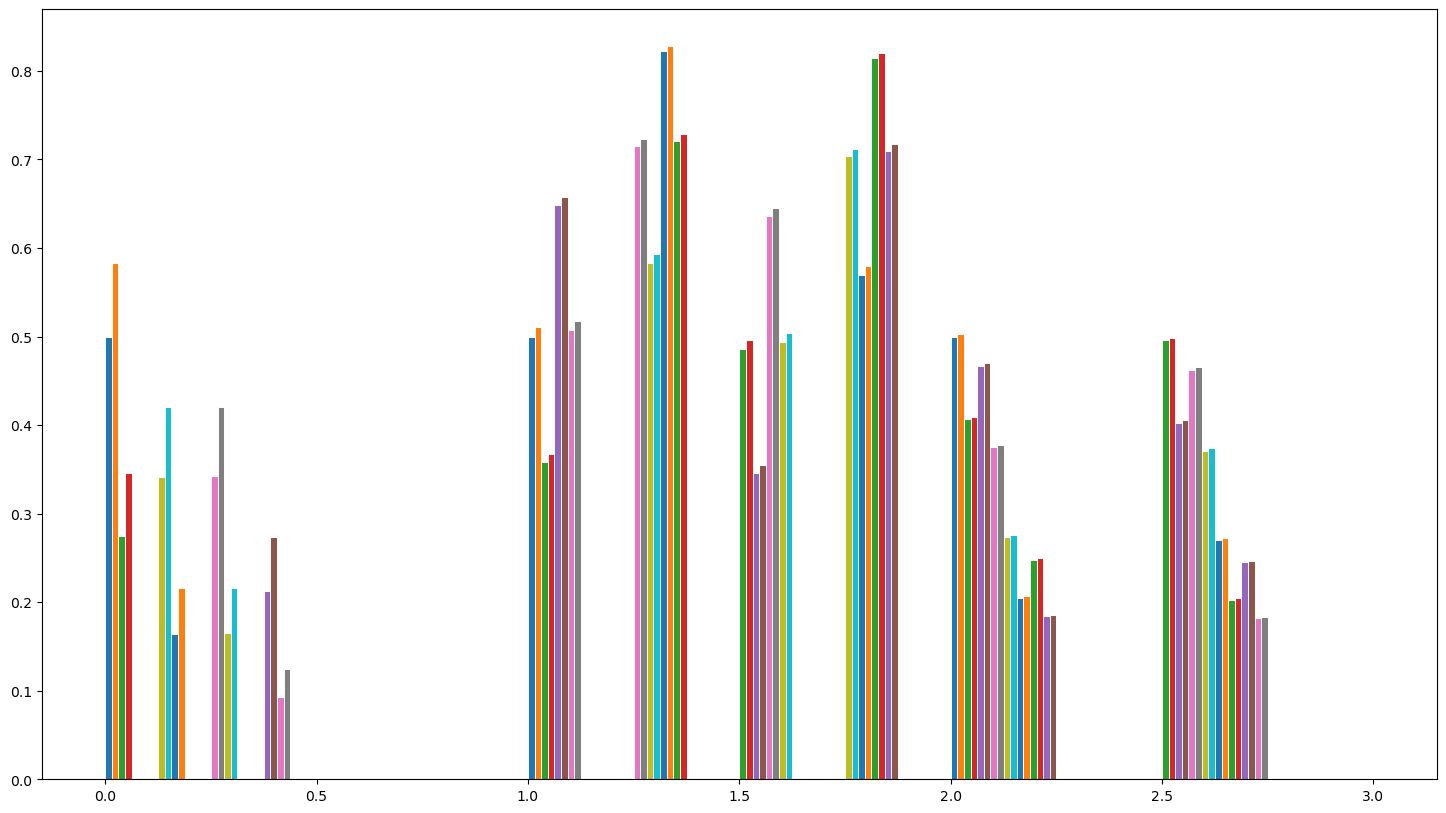

In [928]:
fig, ax = plt.subplots(figsize=(18, 10))
prob_mtx = HM.Prob_ft_wake['Prob_23'][:-1,:-1]
x_size = prob_mtx.shape[0]
y_size = prob_mtx.shape[1]
for i in range(x_size):
    ax.bar(np.arange(y_size)+i/x_size, prob_mtx[i,:], width=1/x_size, edgecolor="white", linewidth=0.7,align='edge')
plt.show()

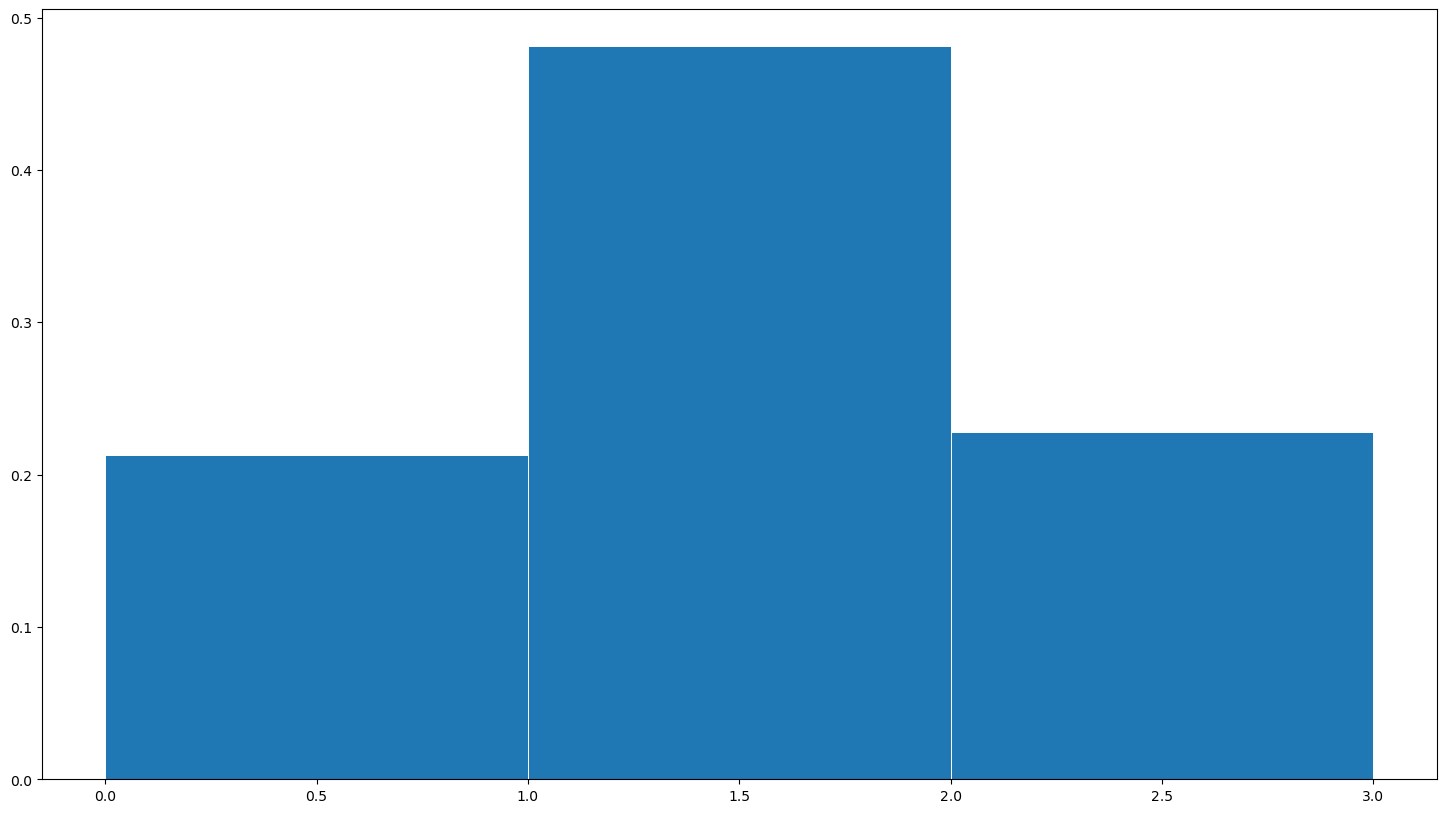

In [634]:
fig, ax = plt.subplots(figsize=(18, 10))
prob_mtx = HM.Prob_ft_wake['Prob_34'][-1:,:-1]
x_size = prob_mtx.shape[0]
y_size = prob_mtx.shape[1]
for i in range(x_size):
    ax.bar(np.arange(y_size)+i/x_size, prob_mtx[i,:], width=1/x_size, edgecolor="white", linewidth=0.7,align='edge')
plt.show()

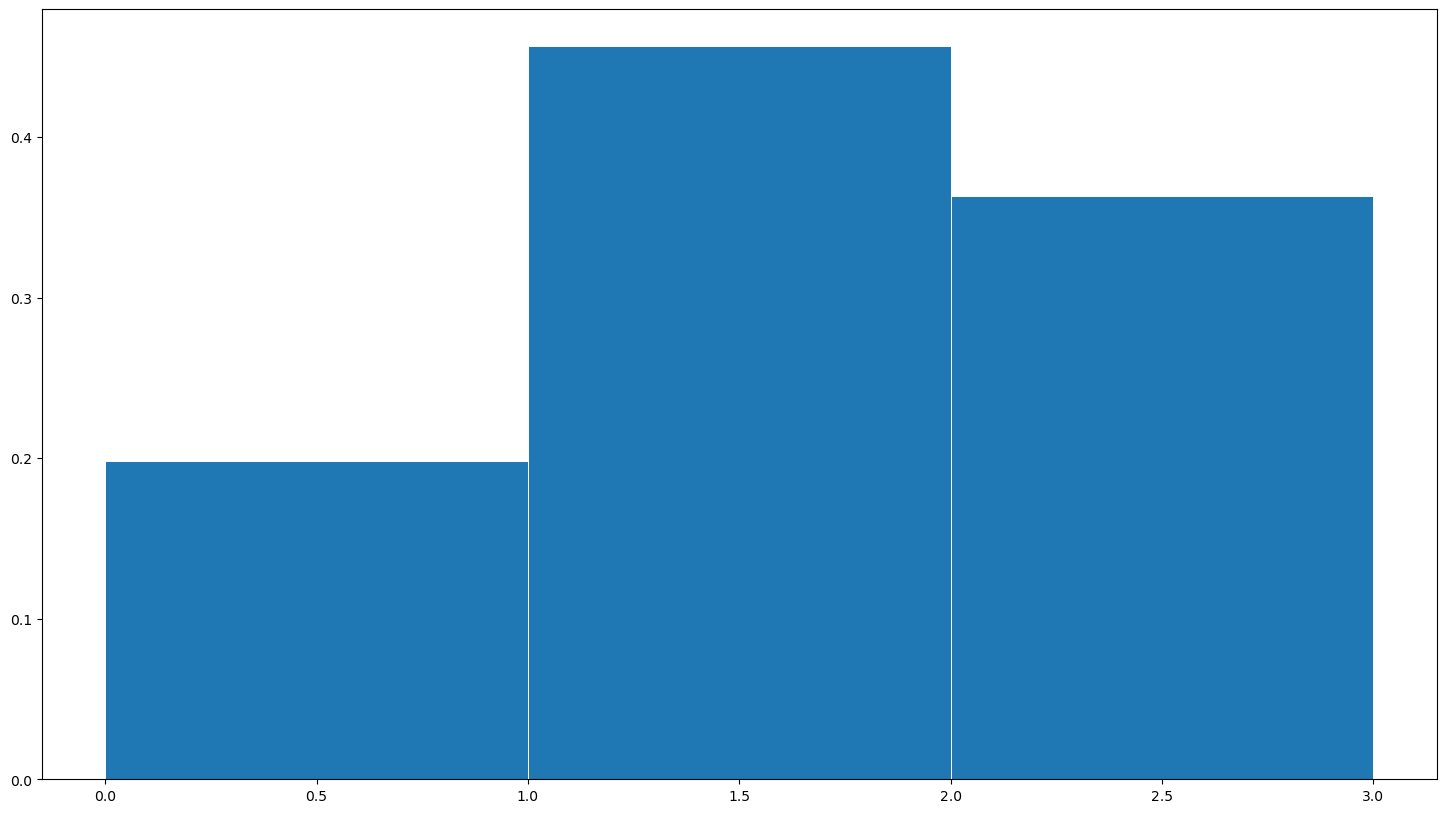

In [635]:
fig, ax = plt.subplots(figsize=(18, 10))
prob_mtx = HM.Prob_ft_sleep['Prob_54'][-1:,:-1]
x_size = prob_mtx.shape[0]
y_size = prob_mtx.shape[1]
for i in range(x_size):
    ax.bar(np.arange(y_size)+i/x_size, prob_mtx[i,:], width=1/x_size, edgecolor="white", linewidth=0.7,align='edge')
plt.show()

In [636]:
start_pattern = HM.Prob_cat_sleep['Prob_43'][0,:-1]
target_layer = 0

In [637]:
p = (start_pattern.reshape(-1,1) * HM.Prob_cat_sleep['Prob_32'][:-1,:-1]).sum(axis=0)
p = (p.reshape(-1,1) * HM.Prob_cat_sleep['Prob_21'][:-1,:-1]).sum(axis=0)
p = (p.reshape(-1,1) * HM.Prob_cat_sleep['Prob_10'][:-1,:-1]).sum(axis=0)

In [638]:
def gen_dist(key_num,p_row,tg_layer):
    """
    Generation distriution from a given pattern at upper layer
    Arguments:
    key_num -- start layer number, integer
    p_row -- specific pattern chosen at start layer, integer
    tg_layer -- target layer number, integer
    Returns:
    tg_dist -- target distribution at target layer, numpy array of shape (n_tg, ), n_tg is the size of target layer
    """
    keys = [*HM.Prob_cat_sleep]
    p = HM.Prob_cat_sleep[keys[key_num]][p_row,:-1]
    for i in range(key_num+1,len(keys)-tg_layer):
        p = (p.reshape(-1,1) * HM.Prob_cat_sleep[keys[i]][:-1,:-1]).sum(axis=0)
    tg_dist = p
    return tg_dist

In [970]:
key_num = 1 # ['Prob_43']
tg_layer = 0 # generation
keys = [*HM.Prob_cat_sleep]
p_row_max = HM.Prob_cat_sleep[keys[key_num]].shape[0]-1
n_tg = HM.Prob_cat_sleep[keys[len(keys)-tg_layer-1]].shape[1]-1
print(p_row_max)
print(n_tg)

8
1024


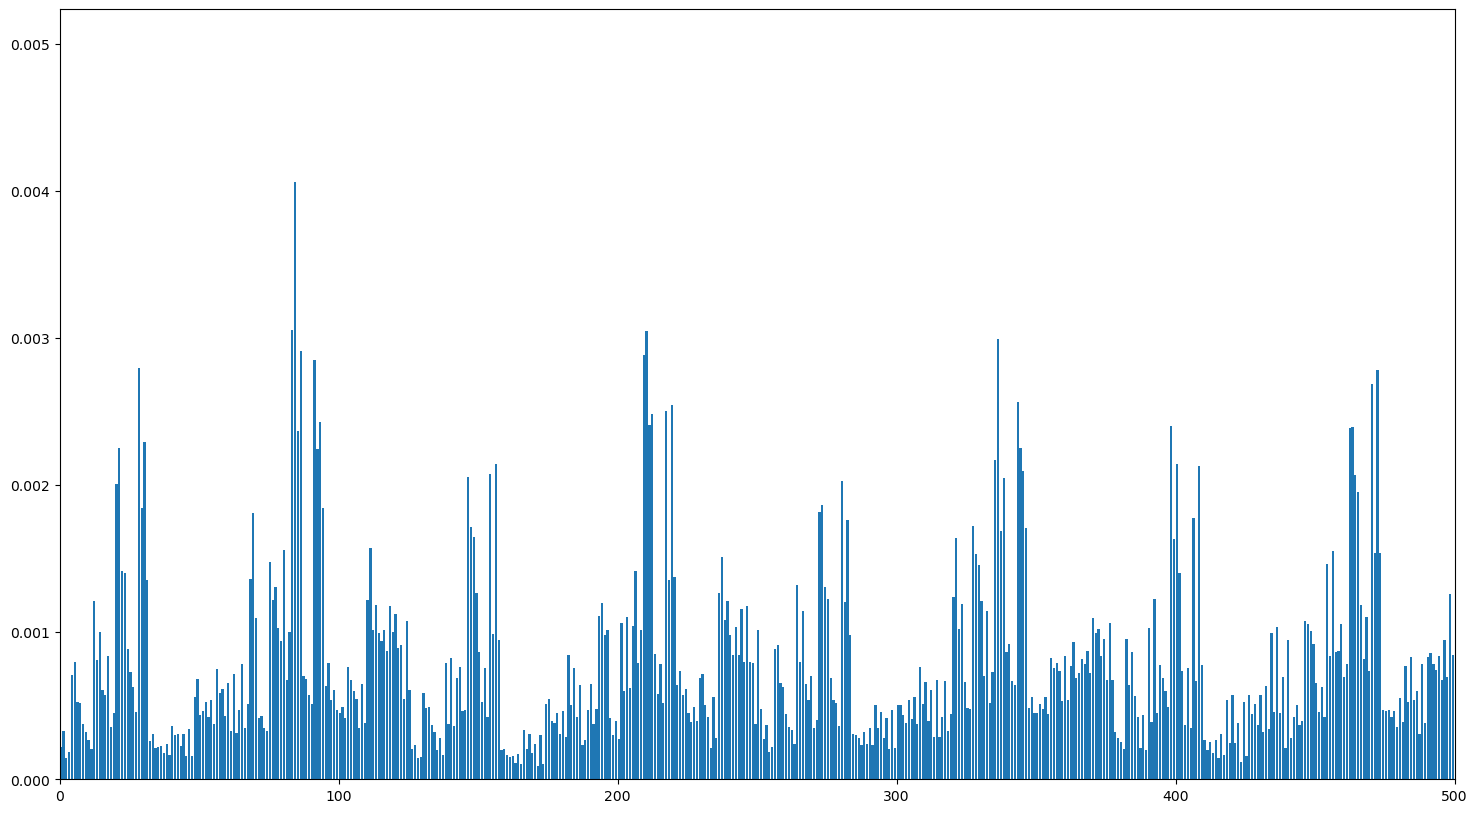

In [872]:
p_row = 0
tg_dist = gen_dist(key_num,p_row,tg_layer)

# x_lim = n_tg
# n_ticks = 8
# xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
# xtick[np.argmin(np.abs(xtick - counts_d.size))] = counts_d.size
# xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(np.arange(tg_dist.size), tg_dist[reordered_set], align='edge')
# ax.set(xlim=(0, x_lim), xticks=xtick)
ax.set(xlim=(0, n_data))
plt.show()

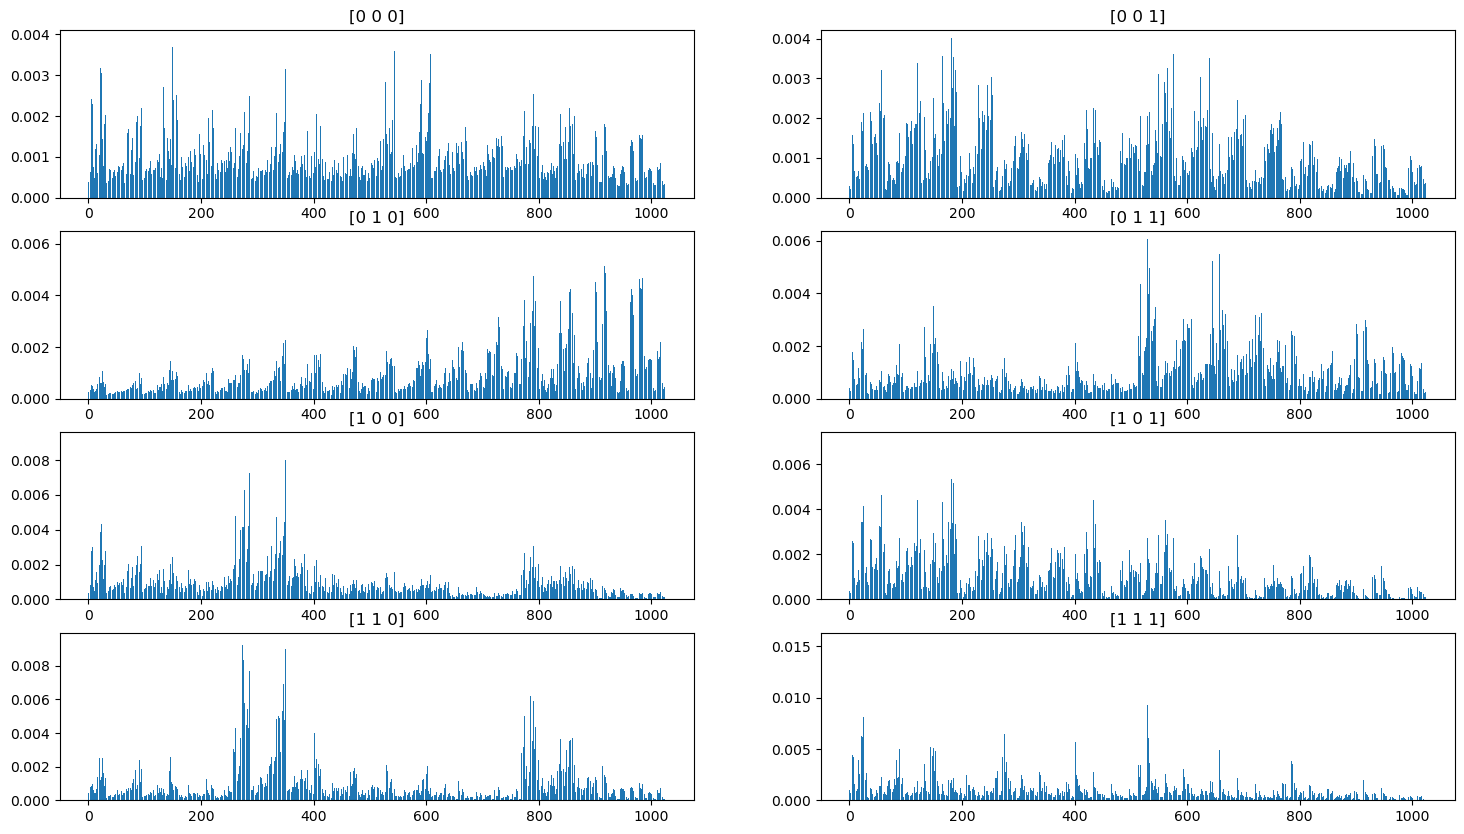

In [1003]:
comb = binarilize(np.arange(p_row_max),int(np.log2(p_row_max)))
fig, ax = plt.subplots(int(p_row_max/2), 2,figsize=(18, 10))
for i in range(p_row_max):
    tg_dist = gen_dist(key_num,i,tg_layer)
    ax[int(i/2),np.mod(i,2)].bar(np.arange(tg_dist.size), tg_dist, align='edge')
#     ax[int(i/2),np.mod(i,2)].set(xlim=(0, n_data))
    ax[int(i/2),np.mod(i,2)].set_title(str(comb[:,i]))
plt.show()

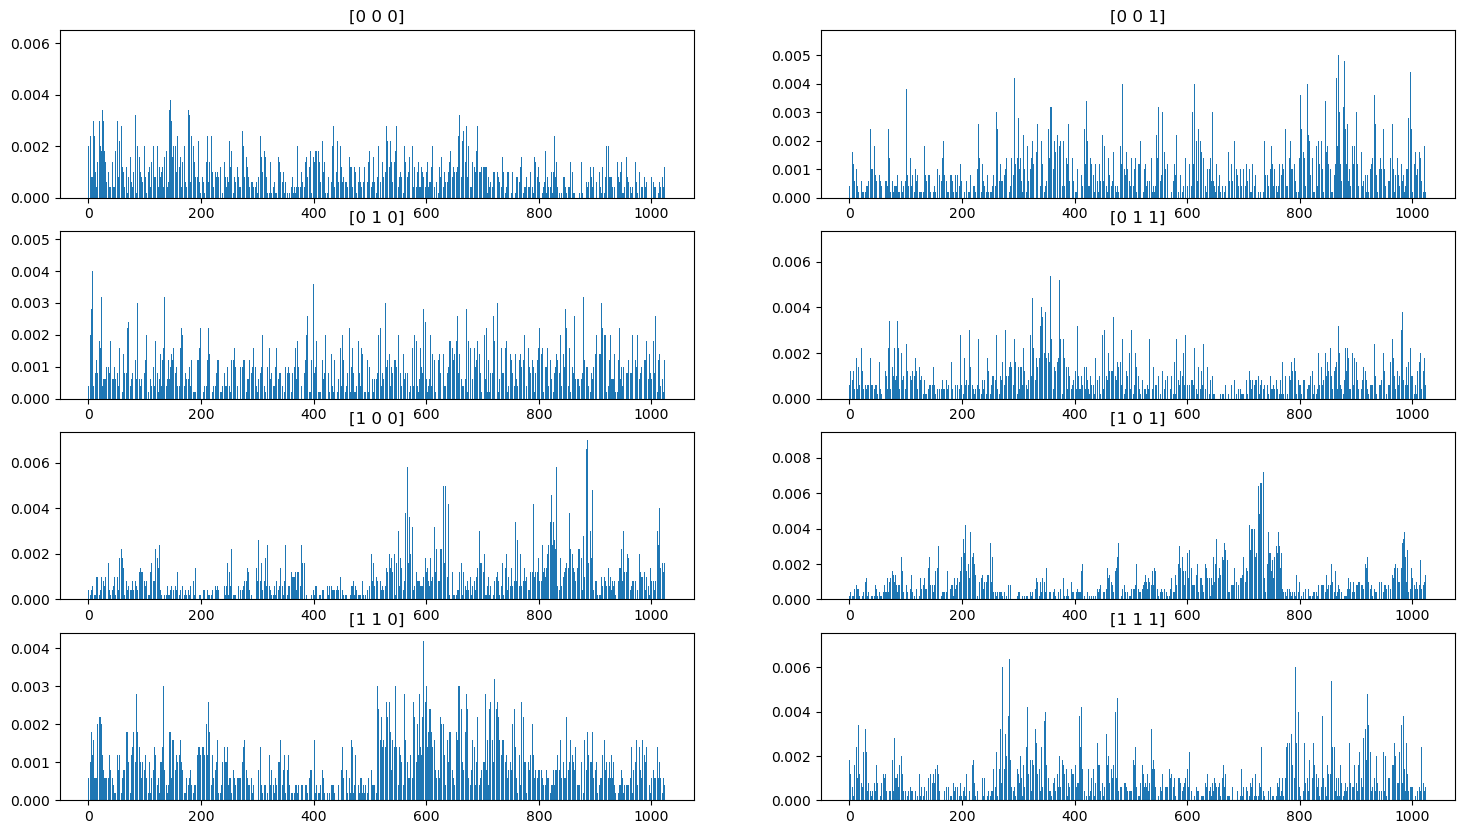

In [998]:
fig, ax = plt.subplots(int(p_row_max/2), 2,figsize=(18, 10))
for i in range(p_row_max):
    prob = np.random.randn(HM.n_d,n_sample) + u[:,i:i+1]
    index = decimalize((prob>0.5).astype(int))
    values_i, counts_i = np.unique(index, return_counts=True)
    y = np.zeros((2**HM.n_d,))
    y[values_i] = counts_i/n_sample
    
    ax[int(i/2),np.mod(i,2)].bar(np.arange(2**HM.n_d), y, align='edge')
#     ax[int(i/2),np.mod(i,2)].set(xlim=(0, n_data))
    ax[int(i/2),np.mod(i,2)].set_title(str(comb[:,i]))
plt.show()

In [109]:
# fig, ax = plt.subplots(figsize=(18, 10))
# x_size = p_row_max
# y_size = n_data
# for i in range(x_size):
#     tg_dist = gen_dist(key_num,i,tg_layer)
# #     ax.bar(np.arange(y_size)+i/x_size, tg_dist[reordered_set][:n_data], width=1/x_size, align='edge')
#     ax.bar(np.arange(tg_dist.size), tg_dist[reordered_set], align='edge')
# ax.set(xlim=(0, y_size))
# plt.show()

#### Auralization

#### Categorical entropy corner

In [276]:
p = np.random.rand(10,1)
p

array([[0.18393857],
       [0.35554527],
       [0.14186142],
       [0.70877719],
       [0.67456713],
       [0.81605959],
       [0.65112462],
       [0.13938567],
       [0.29808115],
       [0.32371686]])

In [277]:
comb = binarilize(np.arange(2**10),10)
comb

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 0, 1]])

In [282]:
p_cat = np.prod(p**comb * (1-p)**(1-comb),axis=0)
entropy(p_cat.reshape(1,-1))

array([5.53737328])

In [285]:
-(p*np.log(p) + (1-p)*np.log(1-p)).sum()

5.537373276539462

Conclusion: H(all combinations) = $\sum_i H(p_i)$

In [332]:
count_cat = np.random.randint(50,size=2**5)
count_cat

array([39, 27, 13, 17, 45, 12, 14, 34, 44, 20,  3, 24,  8, 18, 43, 43, 29,
       46, 45, 20, 18, 17,  8, 20,  3, 43,  3, 40, 18, 44, 34,  2])

In [333]:
count_cat.sum() # total count

794

In [334]:
p_cat = count_cat/count_cat.sum()
entropy(p_cat.reshape(1,-1))

masked_array(data=[3.267929992522557],
             mask=[False],
       fill_value=1e+20)

In [335]:
comb = binarilize(np.arange(2**5),5)
count_1 = (count_cat*comb).sum(axis=1,keepdims=True) # number of 1
count_1

array([[390],
       [390],
       [378],
       [363],
       [427]])

In [336]:
p = count_1/count_cat.sum()
# p_cat = np.prod(p**comb * (1-p)**(1-comb),axis=0)
# entropy(p_cat.reshape(1,-1))

In [337]:
-(p*np.log(p) + (1-p)*np.log(1-p)).sum()

3.4577496240197028